In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [6]:
pd.options.display.float_format = "{:.2f}".format

In [7]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [8]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [9]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [10]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]
X_ORDER = CONFIG["X_ORDER"]
HUE_ORDER = CONFIG["HUE_ORDER"]

In [11]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [12]:
print(df.index.duplicated())

[False False False ... False False False]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [14]:
# df.index = pd.to_datetime(df["Order Date"])

In [15]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [16]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [17]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [18]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [19]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [20]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [21]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.05, 0.05])

In [22]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [23]:
df["Category-SubCategory"] = df["Category"].str.cat(df["Sub-Category"], sep="-")

In [24]:
df_sample = df.sample(n=3000)

In [25]:
# sns.catplot(
#     data=df_sample, kind="swarm",
#     x="Region", y="Sales", hue="Category", col="Order Year",
#     aspect=.5
# )

In [26]:
# sns.catplot(
#     data=df_sample, kind="swarm",
#     x="Region", y="Profit", hue="Category", col="Order Year",
#     aspect=.5
# )

In [27]:
# sns.catplot(
#     data=df_sample, kind="swarm",
#     x="Region", y="Sales", hue="Sub-Category", col="Order Year",
#     aspect=.5
# )

In [28]:
# sns.catplot(
#     data=df_sample, kind="swarm",
#     x="Region", y="Profit", hue="Sub-Category", col="Order Year",
#     aspect=.5
# )

Text(0.5, 0.98, '[Sales]')

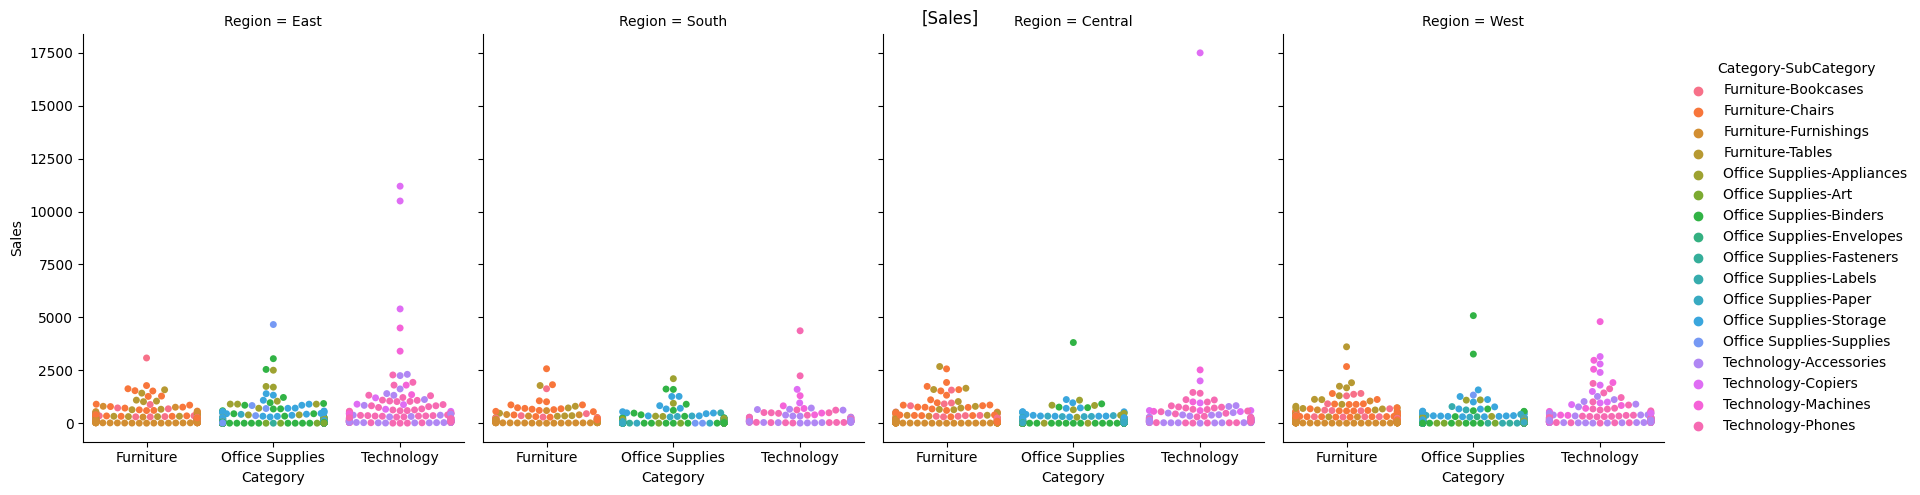

In [29]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region",
    aspect=.85
)

g.fig.suptitle(f"[Sales]")

2014
2015
2016
2017


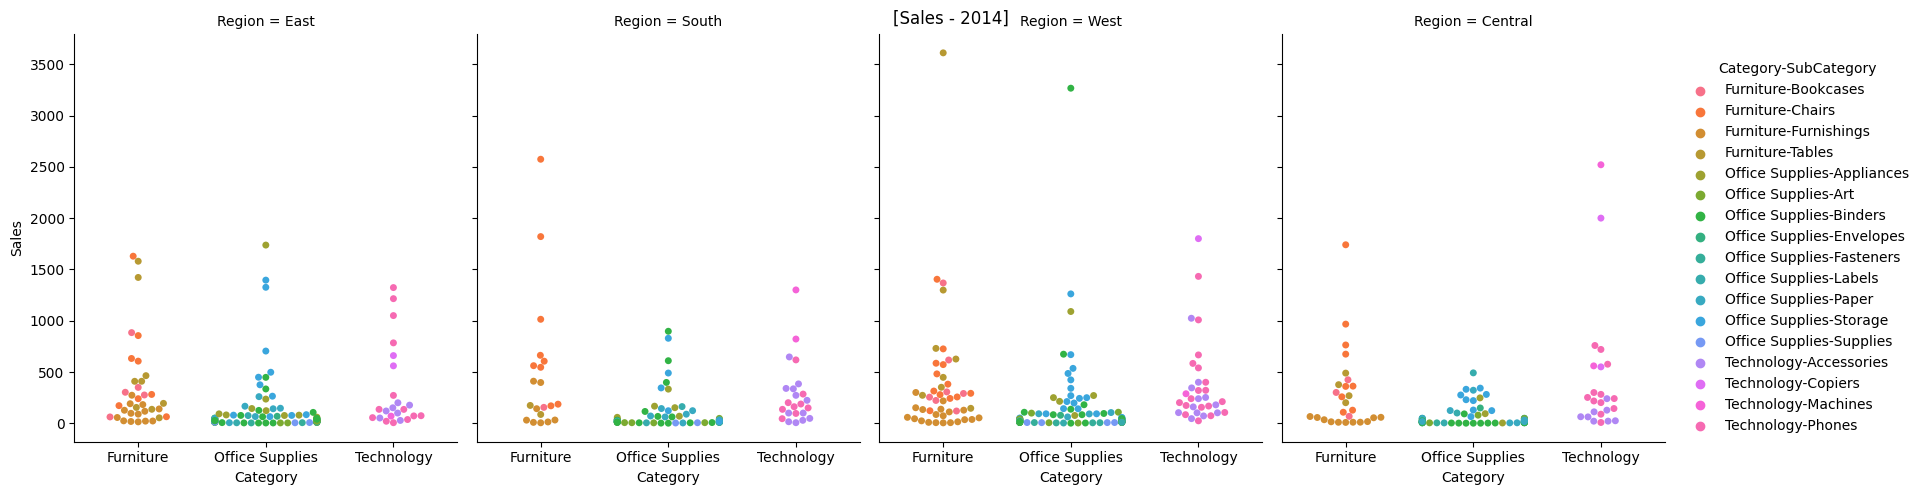

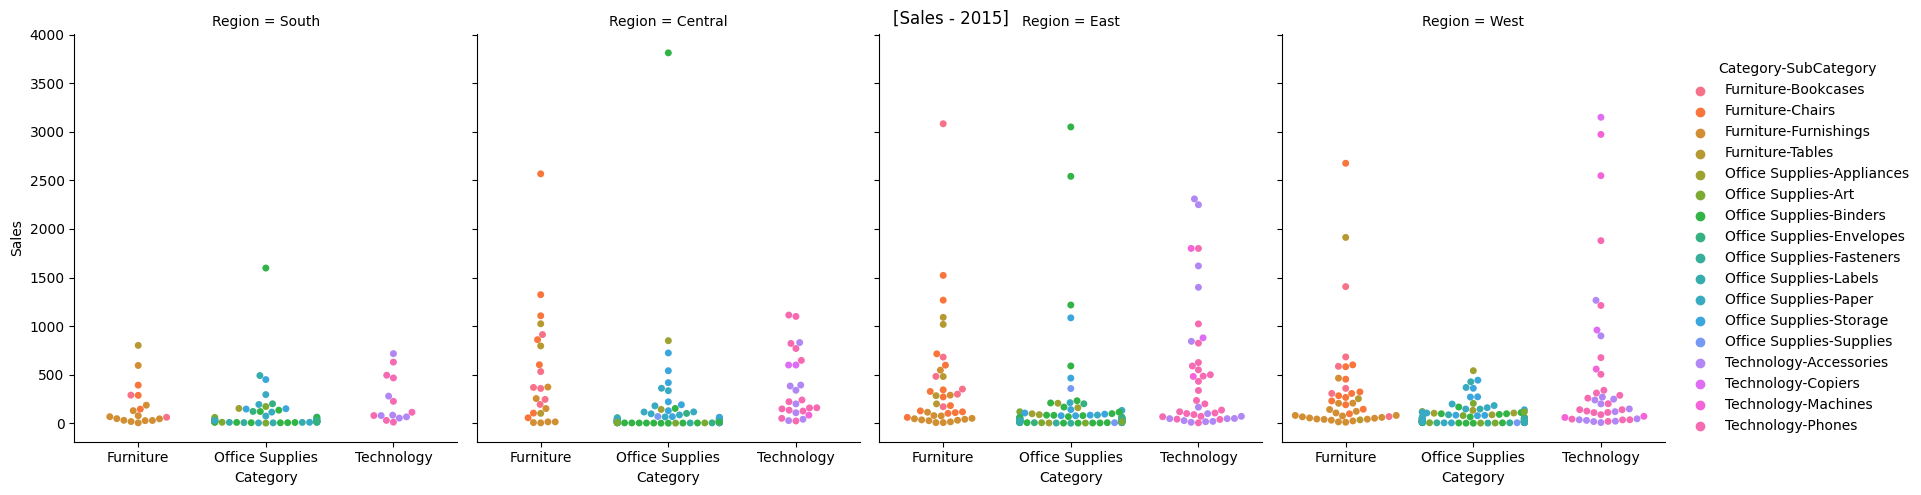

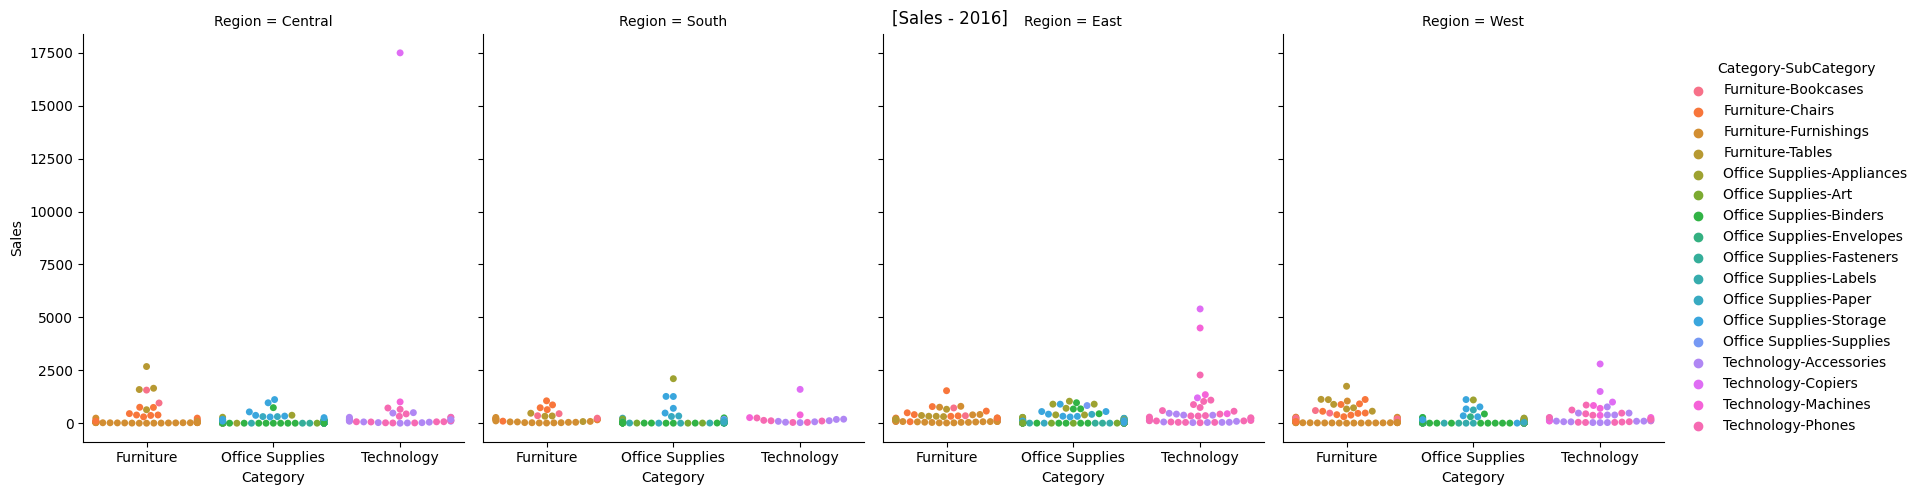

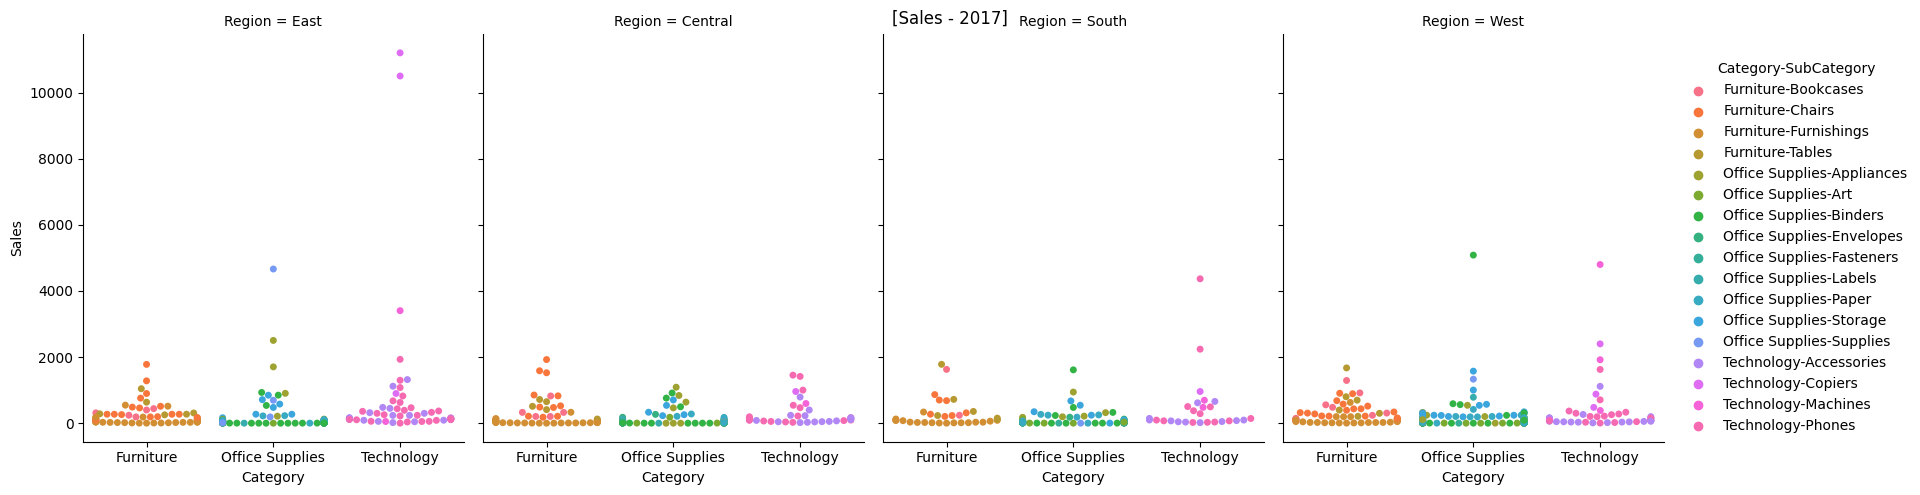

In [30]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Sales", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region",
        aspect=.85
    )
    
    g.fig.suptitle(f"[Sales - {v}]")

Text(0.5, 0.98, '[Profit]')

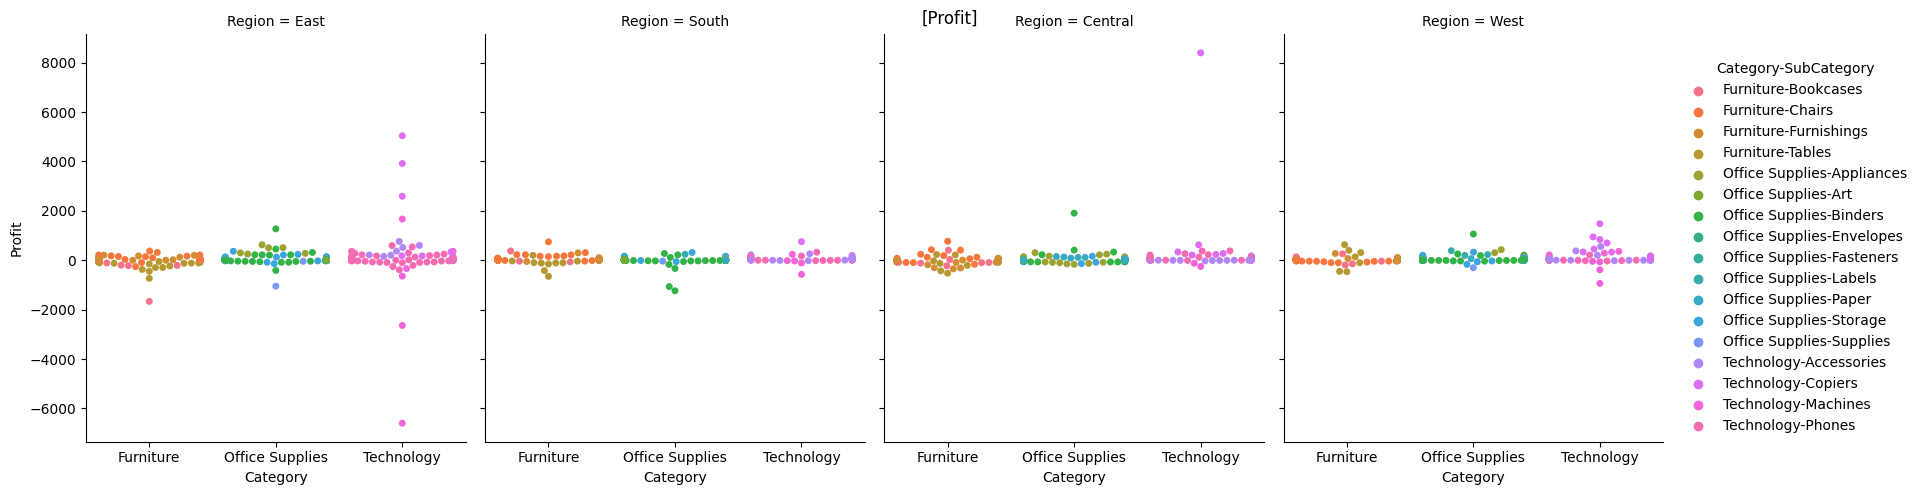

In [31]:
g = sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", order=X_ORDER, y="Profit", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region",
    aspect=.85
)

g.fig.suptitle(f"[Profit]")

2014
2015
2016
2017


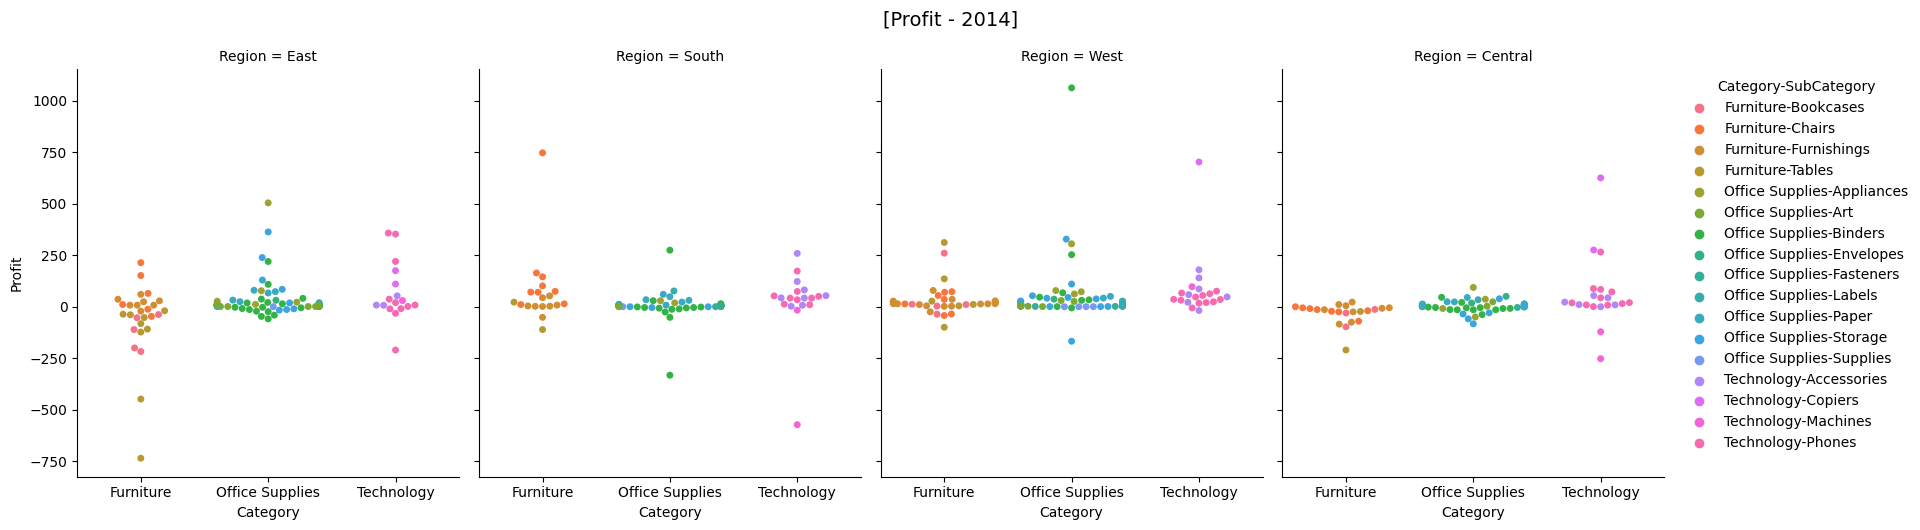

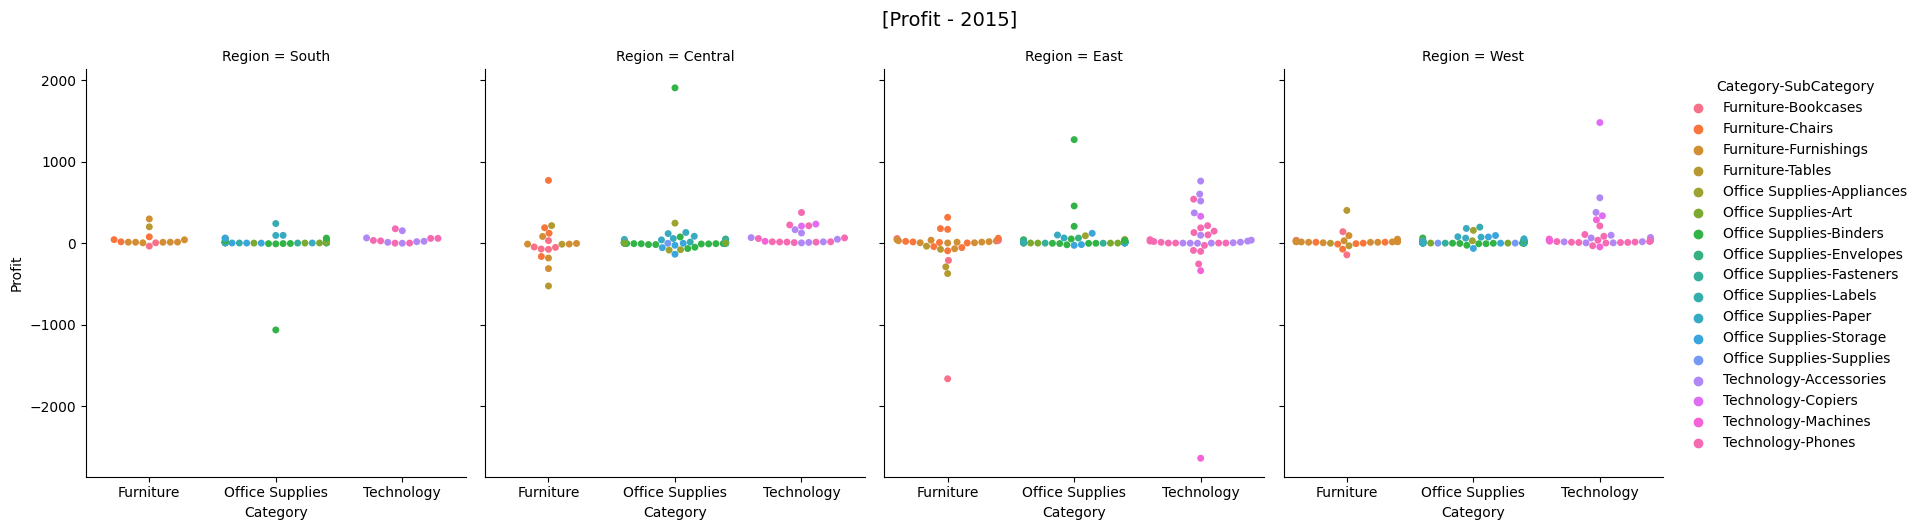

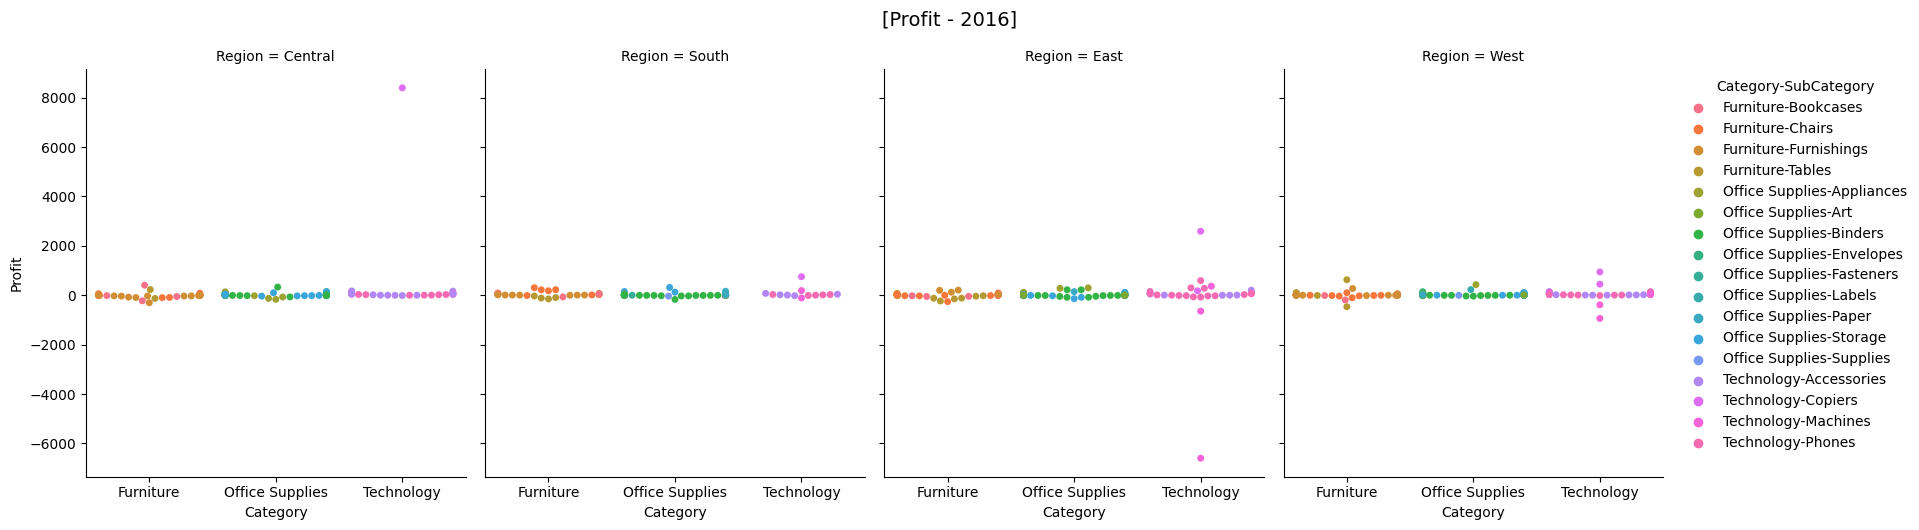

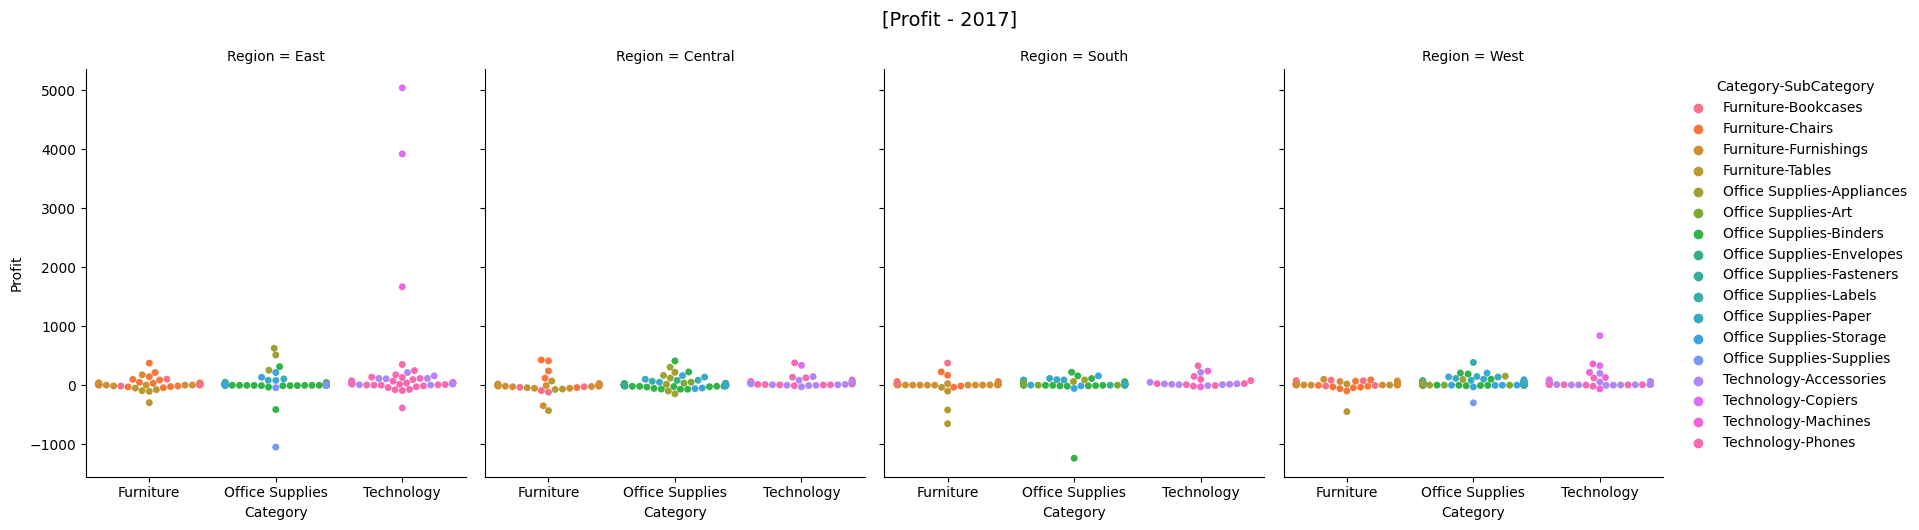

In [32]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", order=X_ORDER, y="Profit", hue="Category-SubCategory", hue_order=HUE_ORDER, col="Region",
        aspect=.85
    )
    
    g.fig.suptitle(f"[Profit - {v}]", fontsize=14, y=1.05)

2014
2015
2016
2017


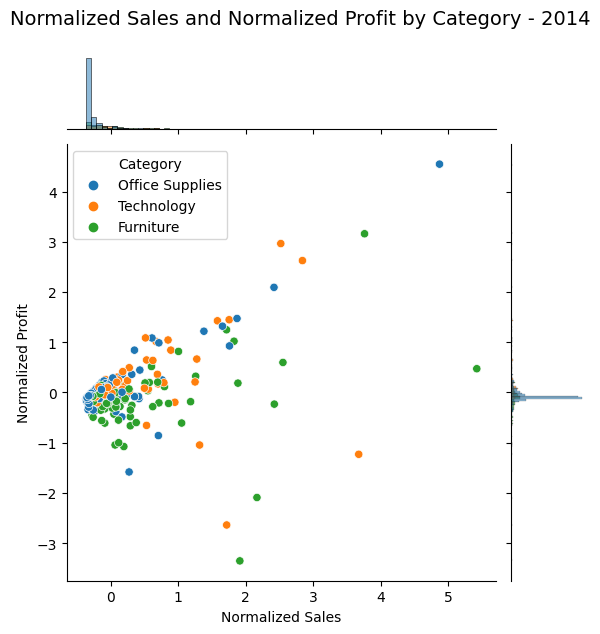

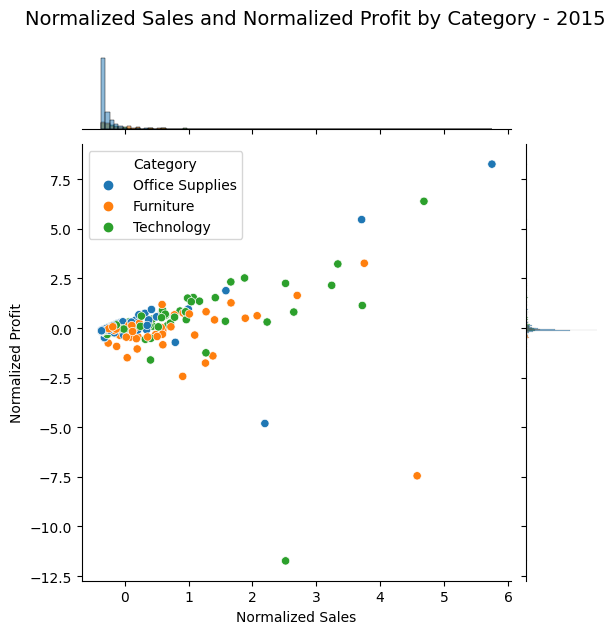

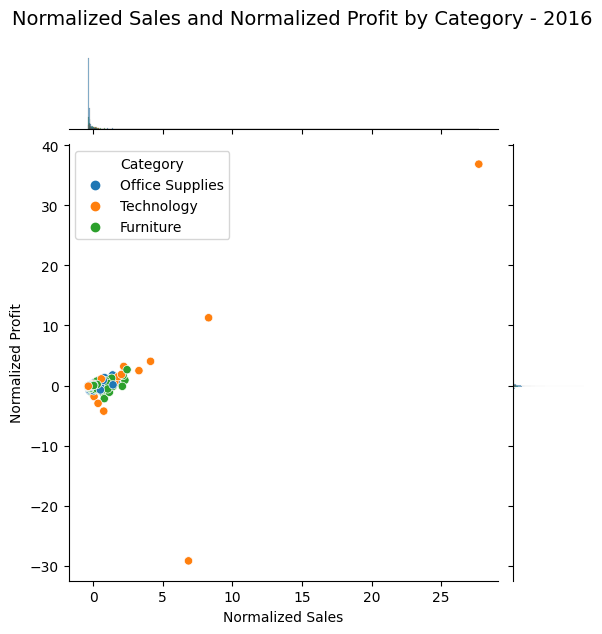

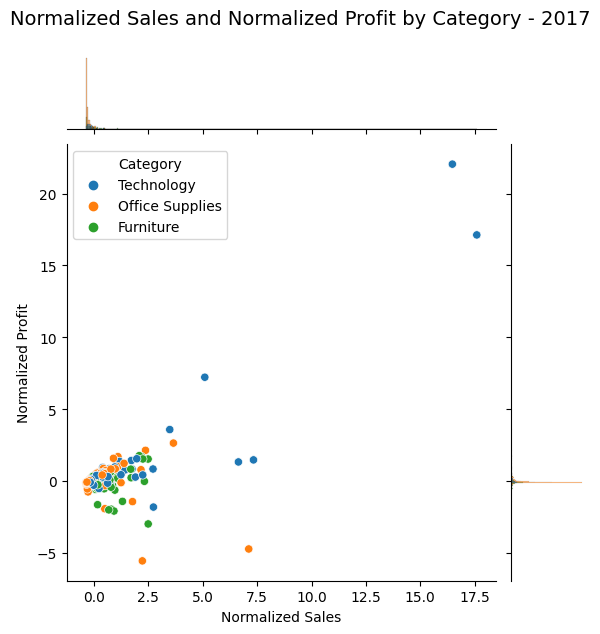

In [33]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Normalized Sales", y="Normalized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(f"Normalized Sales and Normalized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


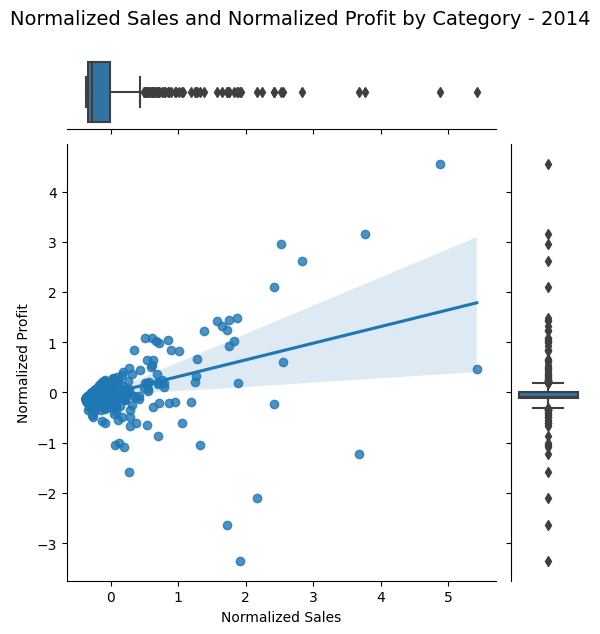

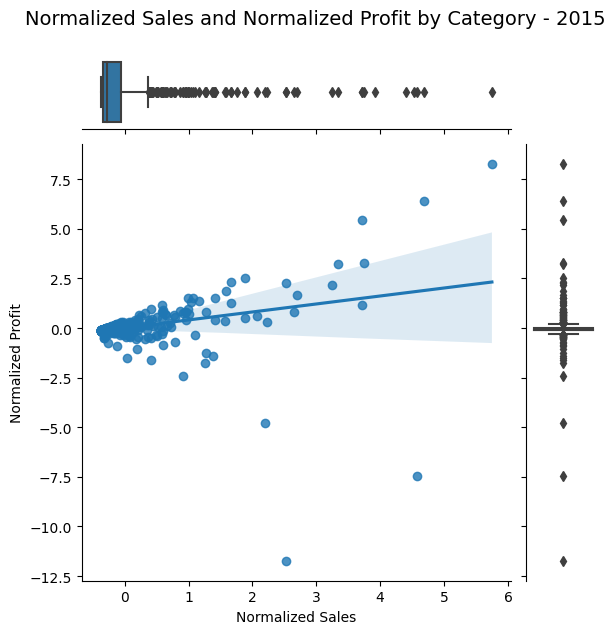

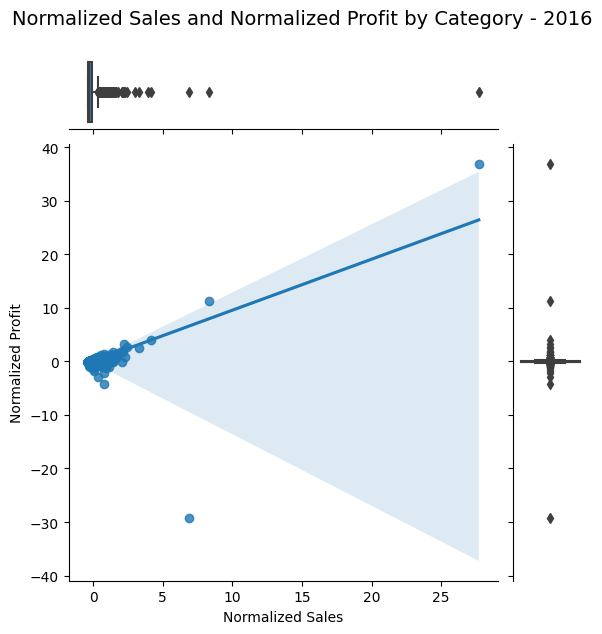

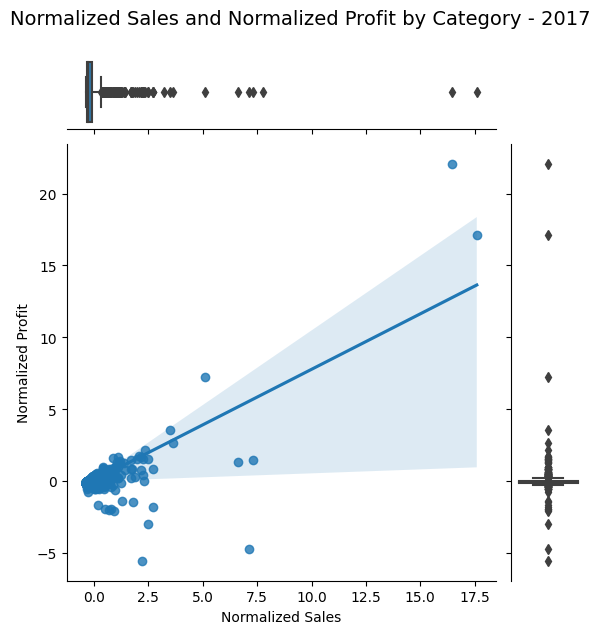

In [34]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Normalized Sales", y="Normalized Profit")
    g.plot(sns.regplot, sns.boxplot)
    g.fig.suptitle(f"Normalized Sales and Normalized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


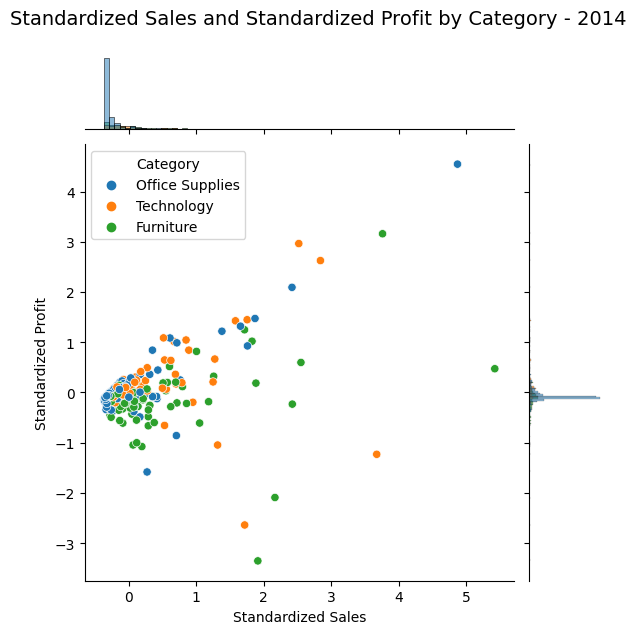

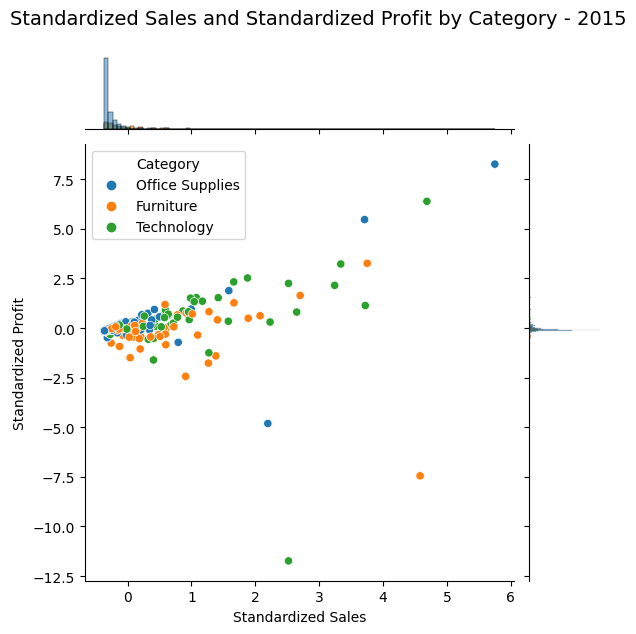

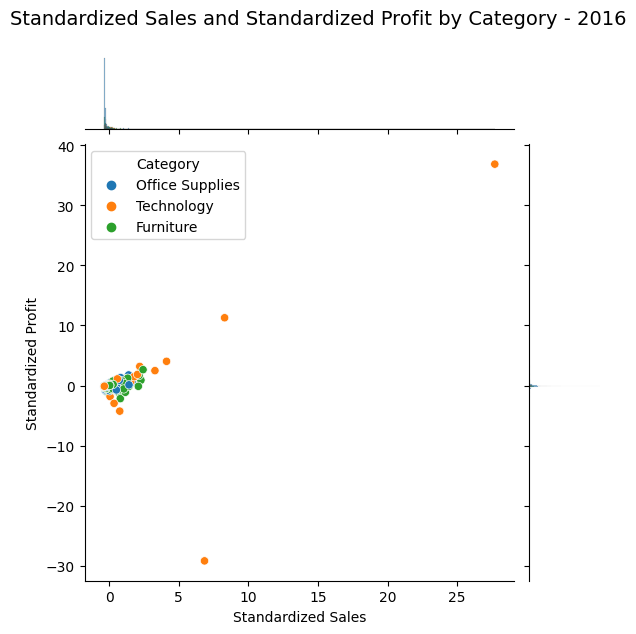

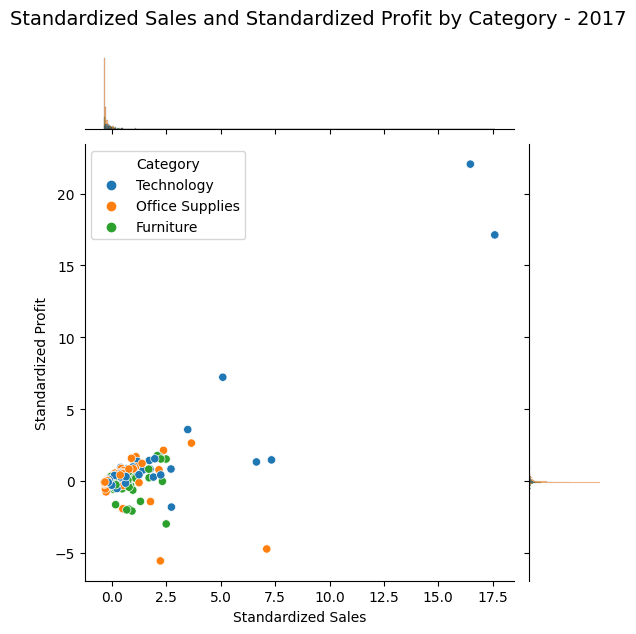

In [35]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Standardized Sales", y="Standardized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(f"Standardized Sales and Standardized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


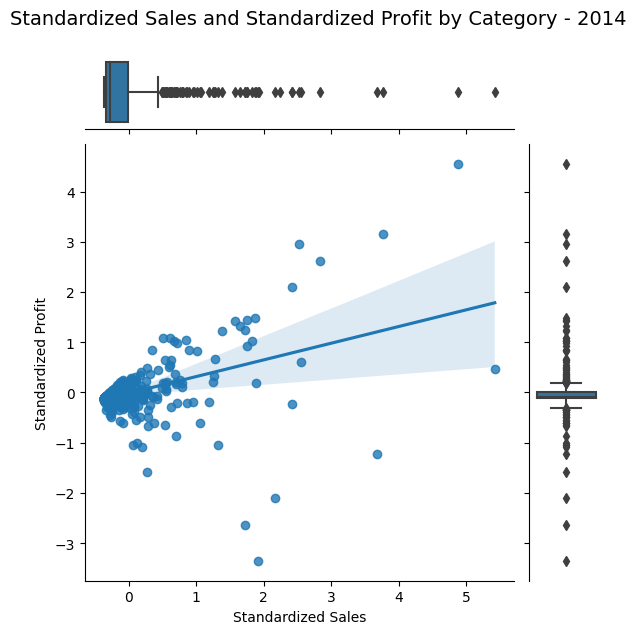

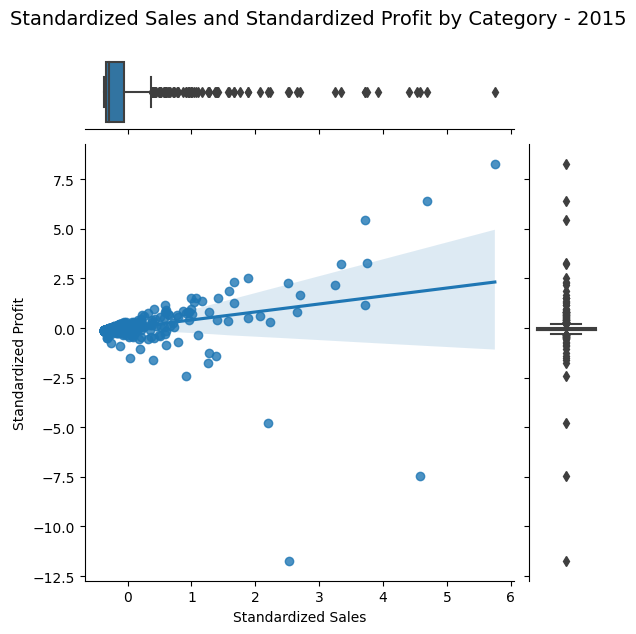

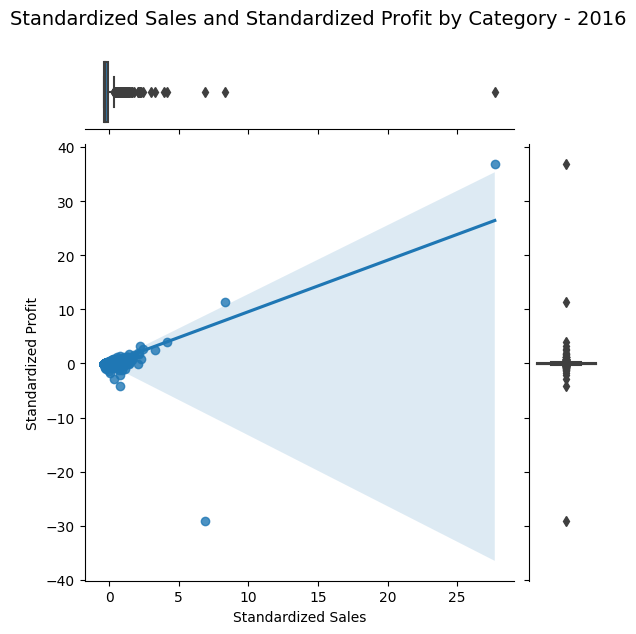

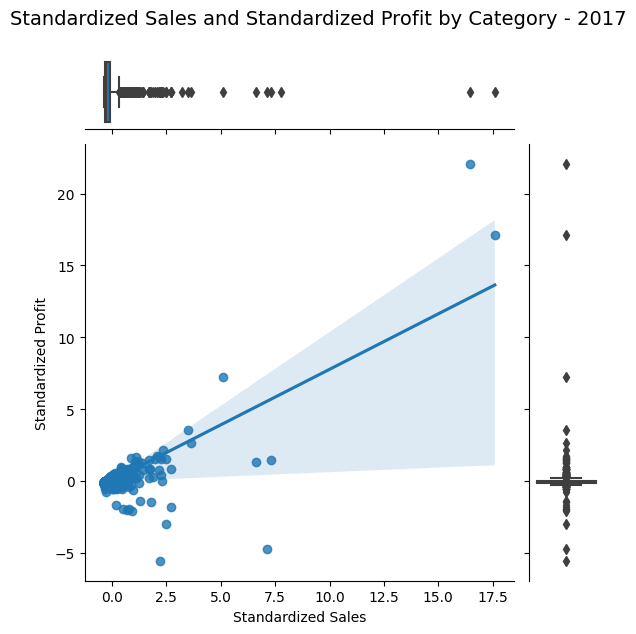

In [36]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Standardized Sales", y="Standardized Profit")
    g.plot(sns.regplot, sns.boxplot)
    g.fig.suptitle(f"Standardized Sales and Standardized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


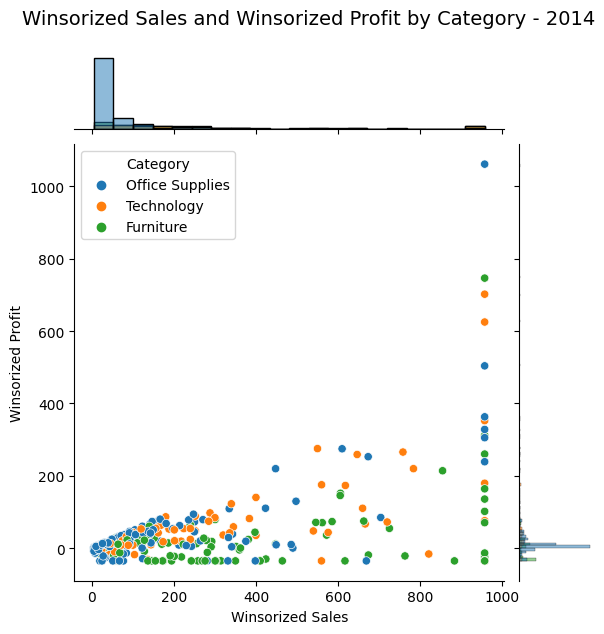

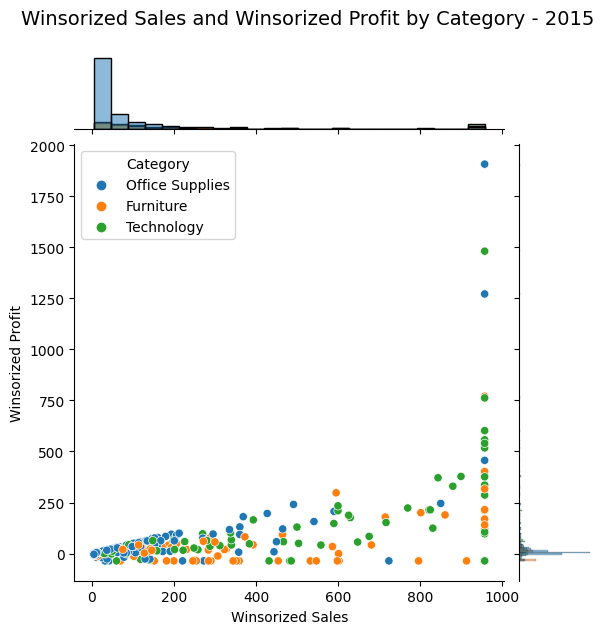

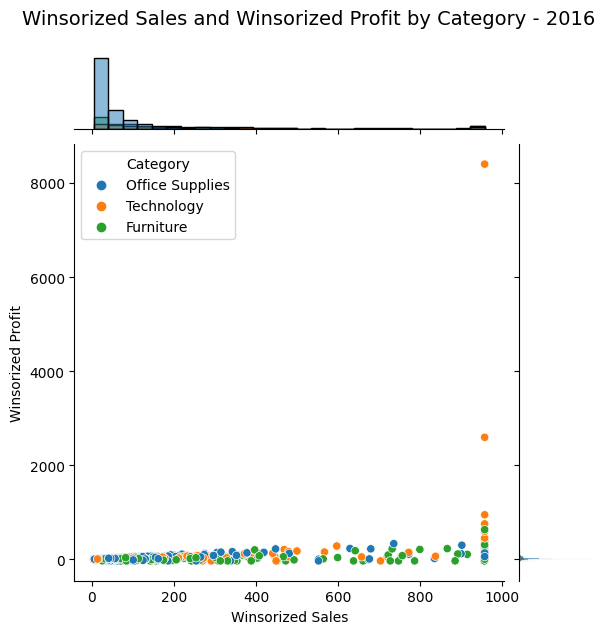

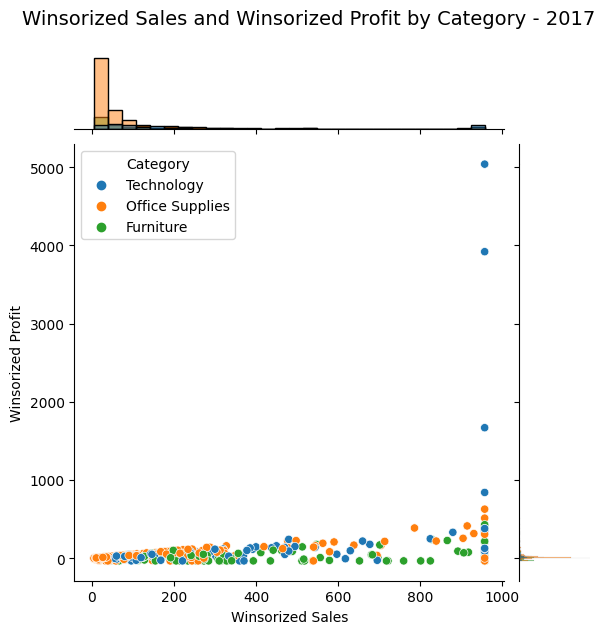

In [37]:
for i, v in enumerate(sorted(sorted(df["Order Year"].unique()))):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Winsorized Sales", y="Winsorized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(f"Winsorized Sales and Winsorized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


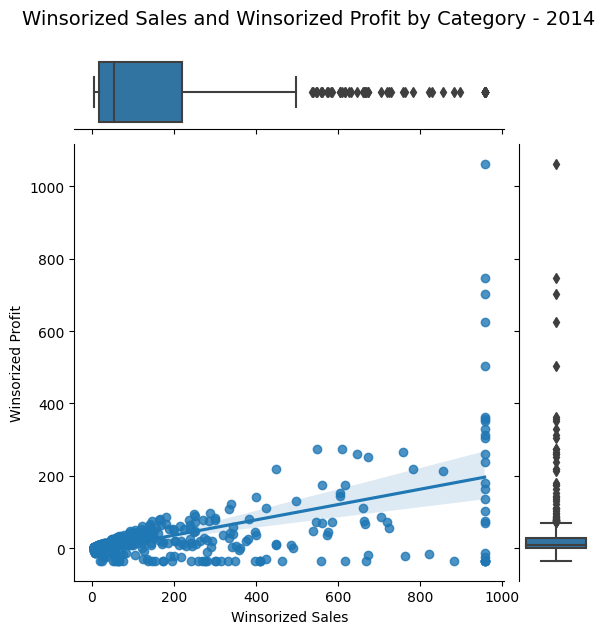

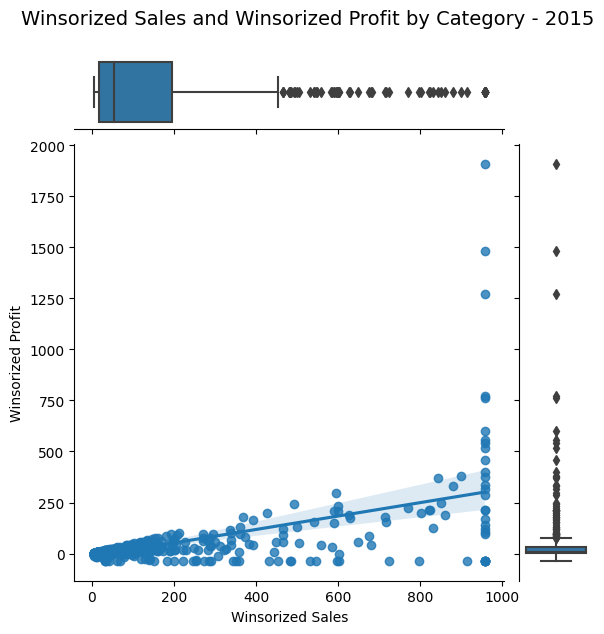

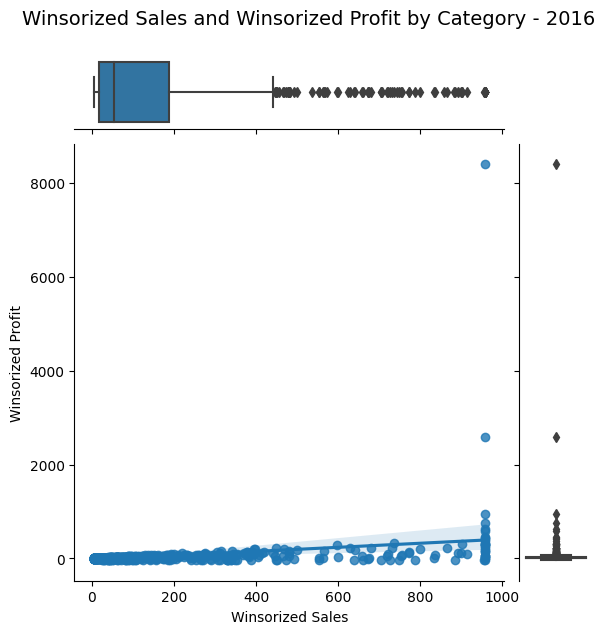

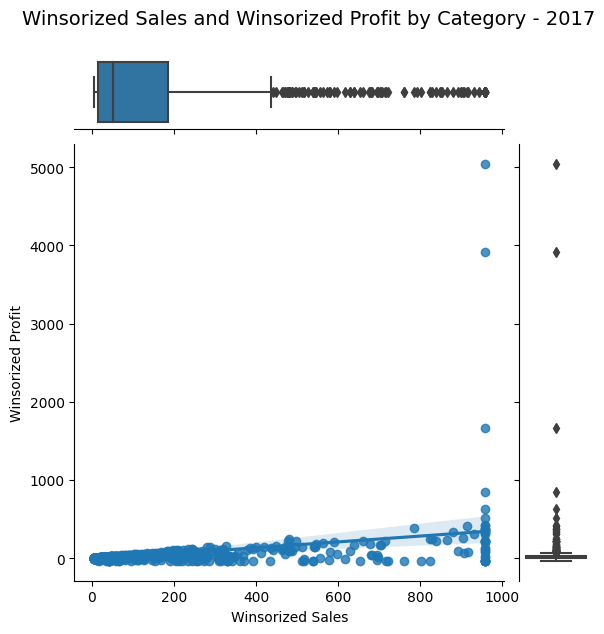

In [38]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Winsorized Sales", y="Winsorized Profit")
    g.plot(sns.regplot, sns.boxplot)
    g.fig.suptitle(f"Winsorized Sales and Winsorized Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


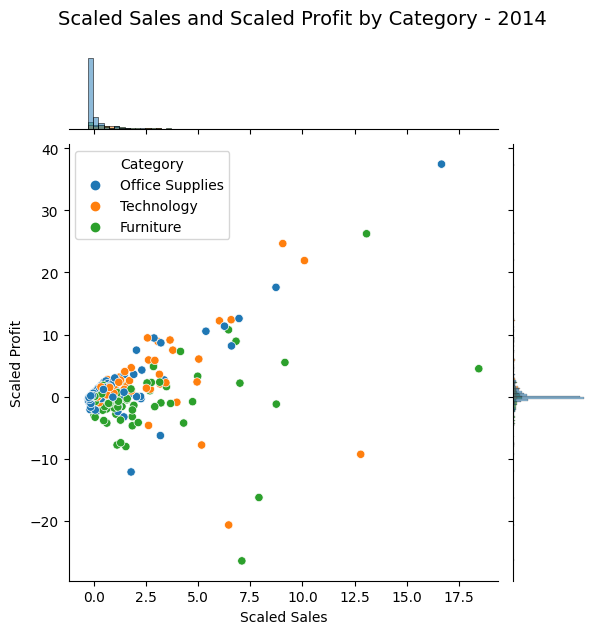

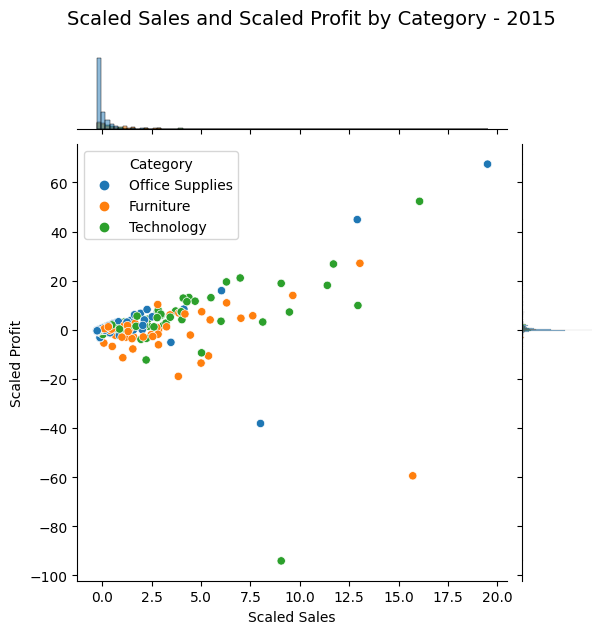

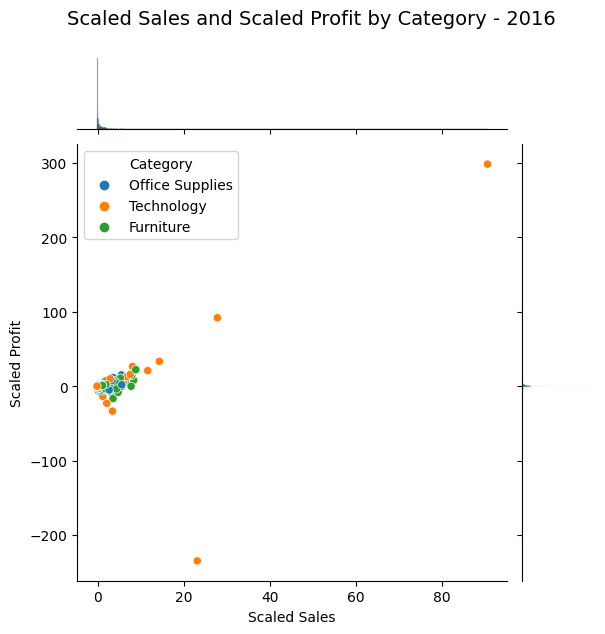

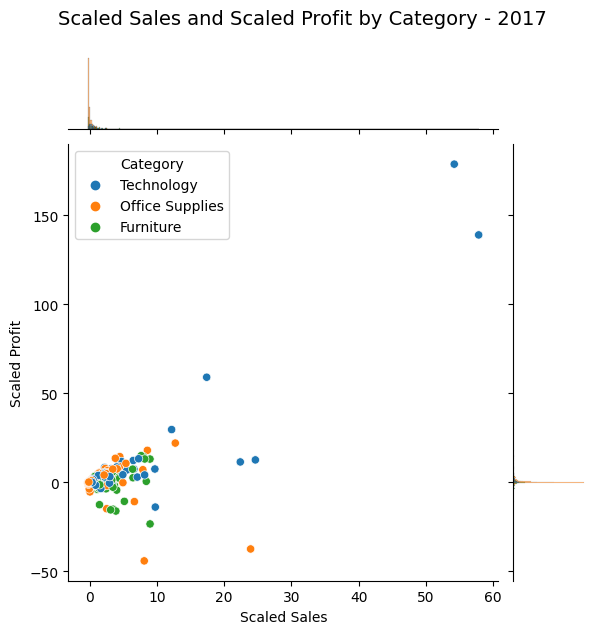

In [39]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Scaled Sales", y="Scaled Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)
    g.fig.suptitle(f"Scaled Sales and Scaled Profit by Category - {v}", fontsize=14, y=1.05)

2014
2015
2016
2017


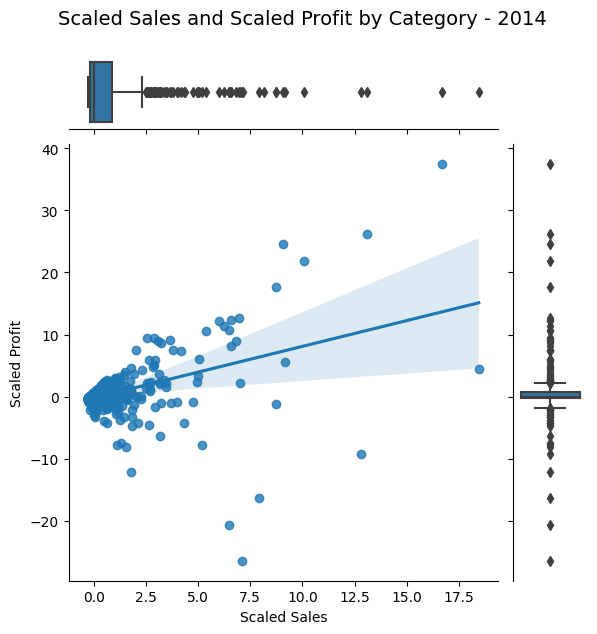

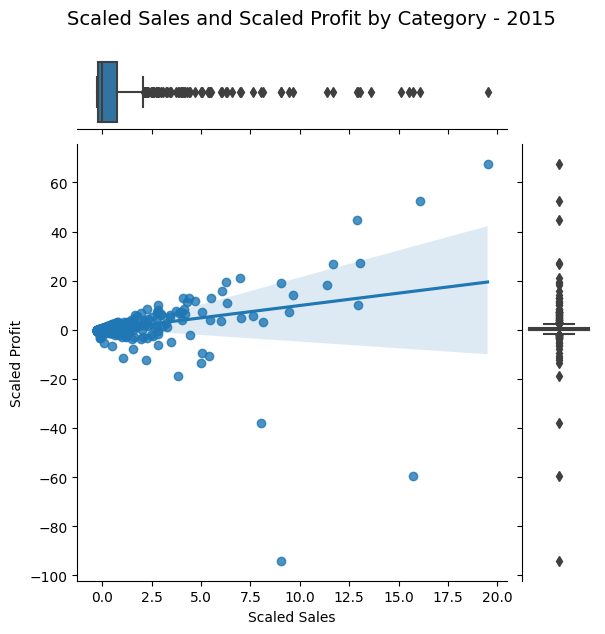

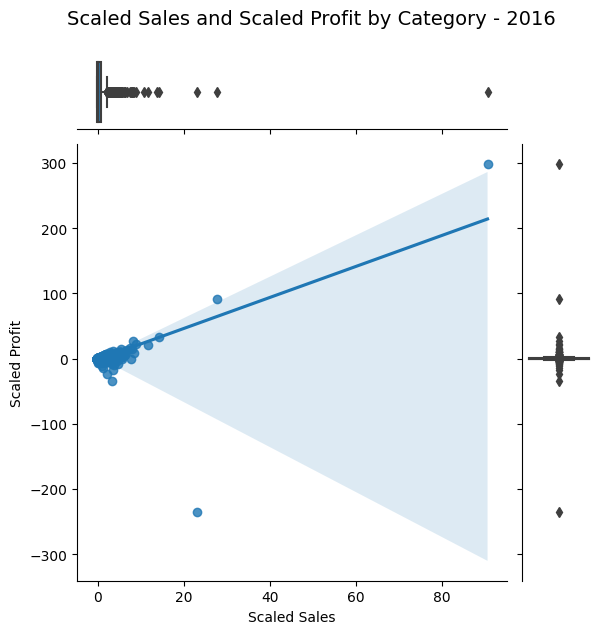

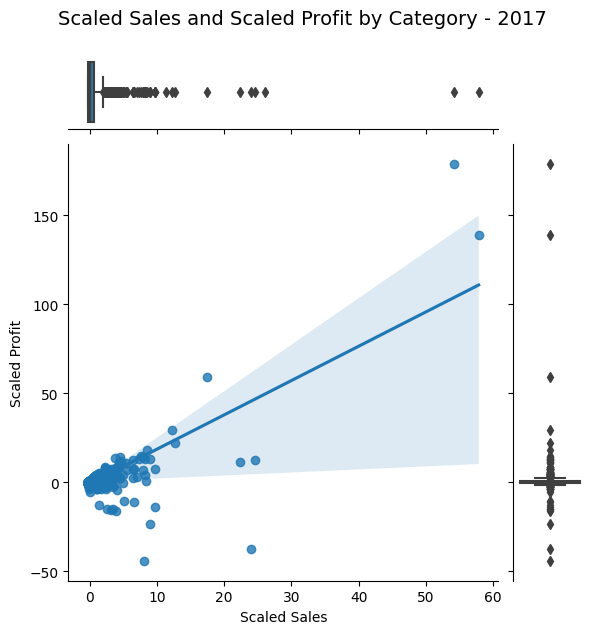

In [40]:
for i, v in enumerate(sorted(df["Order Year"].unique())):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Scaled Sales", y="Scaled Profit")
    g.plot(sns.regplot, sns.boxplot)
    g.fig.suptitle(f"Scaled Sales and Scaled Profit by Category - {v}", fontsize=14, y=1.05)

In [41]:
df_sample.index = pd.to_datetime(df_sample["Order Date"])

# Monthly Profit

Technology


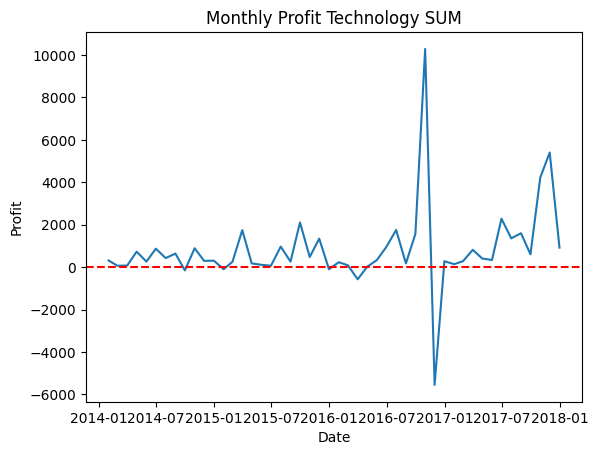

Office Supplies


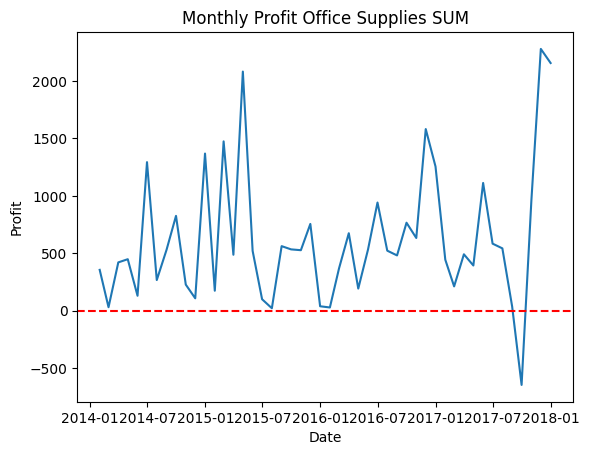

Furniture


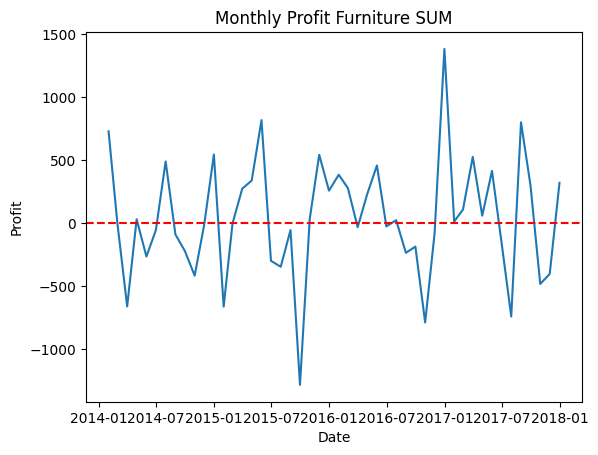

In [42]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').sum()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} SUM")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


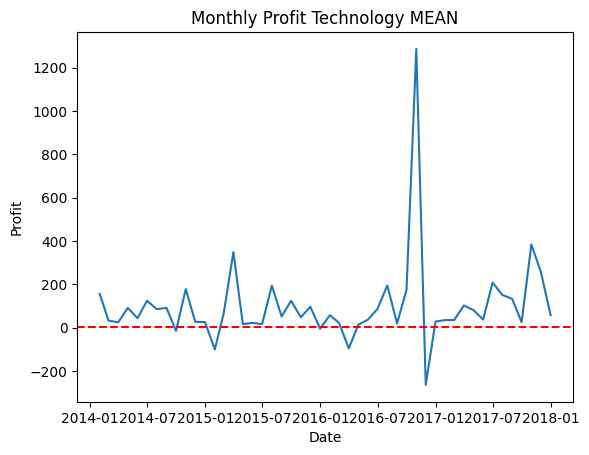

Office Supplies


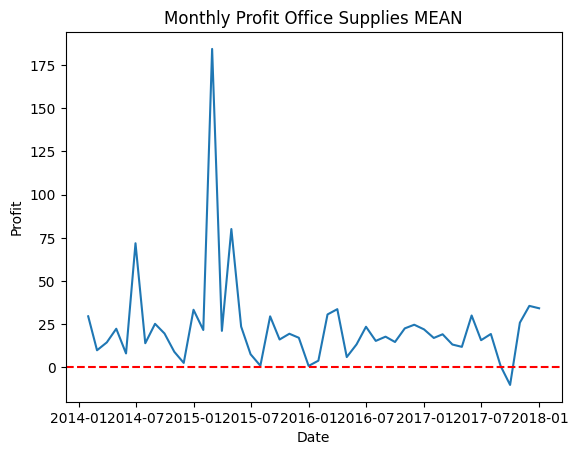

Furniture


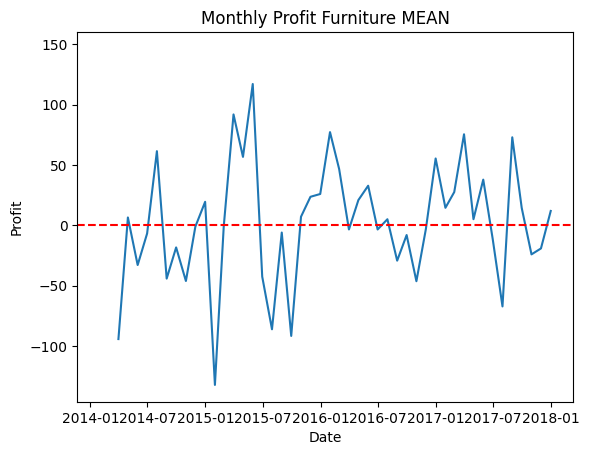

In [43]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').mean()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} MEAN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


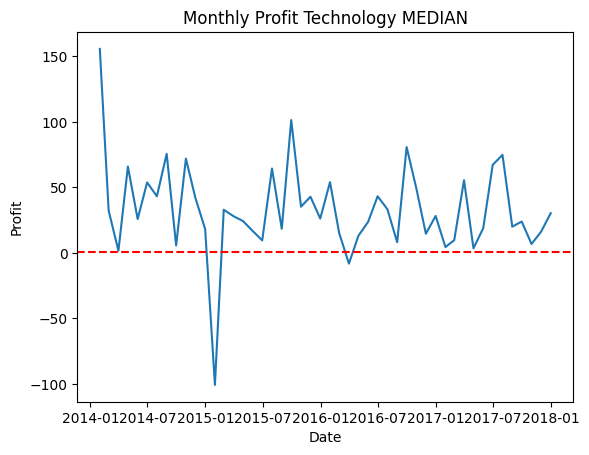

Office Supplies


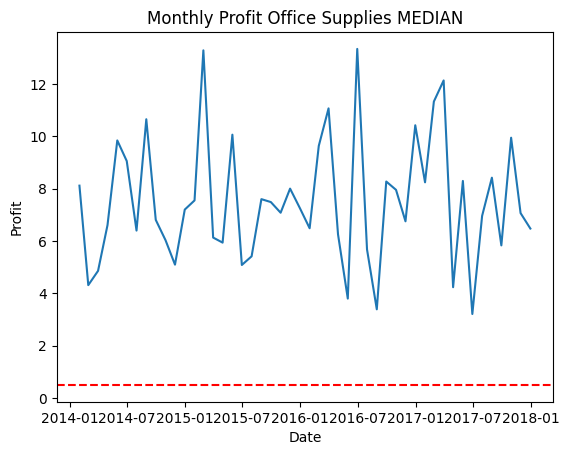

Furniture


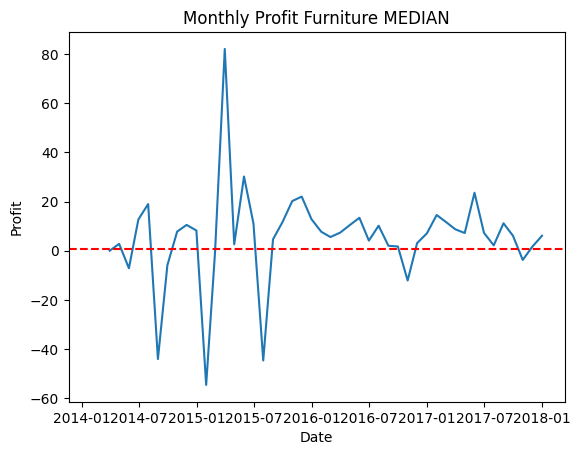

In [44]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').median()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} MEDIAN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


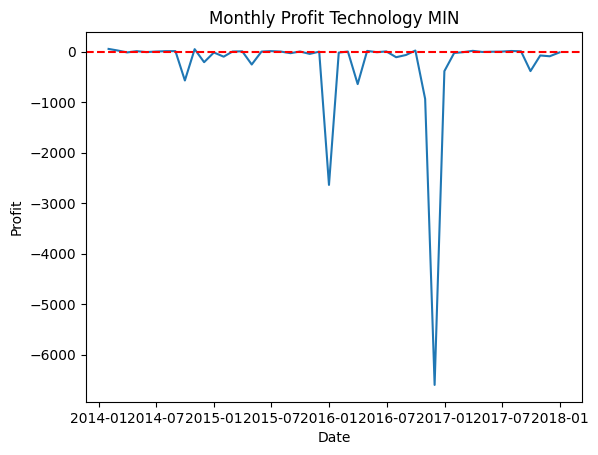

Office Supplies


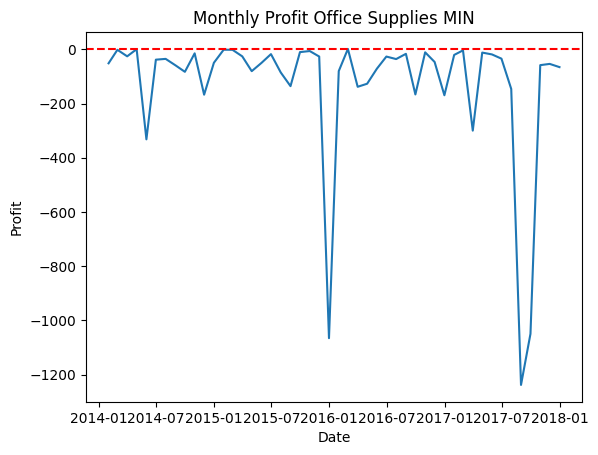

Furniture


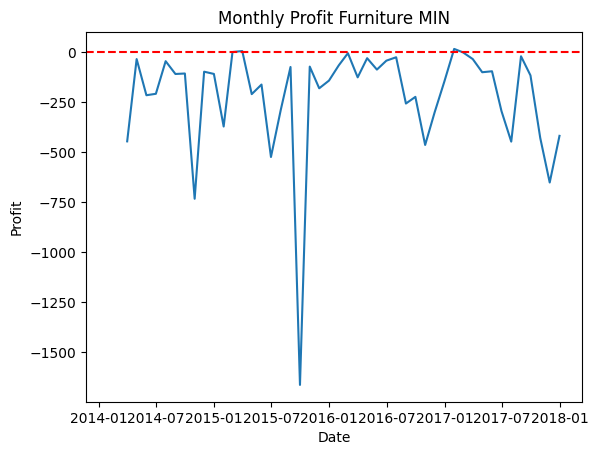

In [45]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').min()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} MIN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


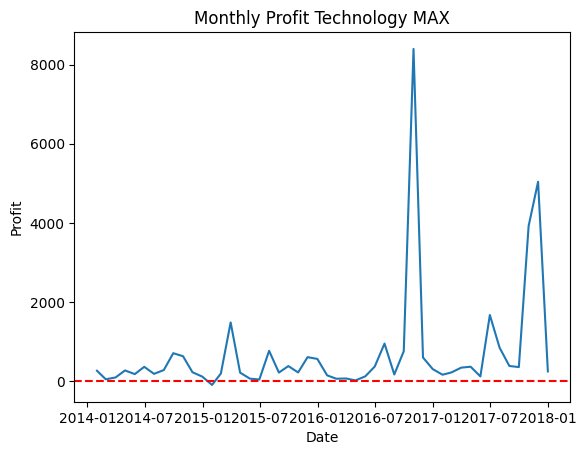

Office Supplies


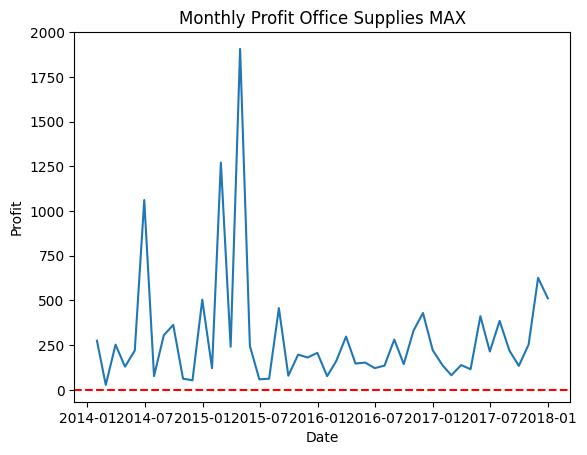

Furniture


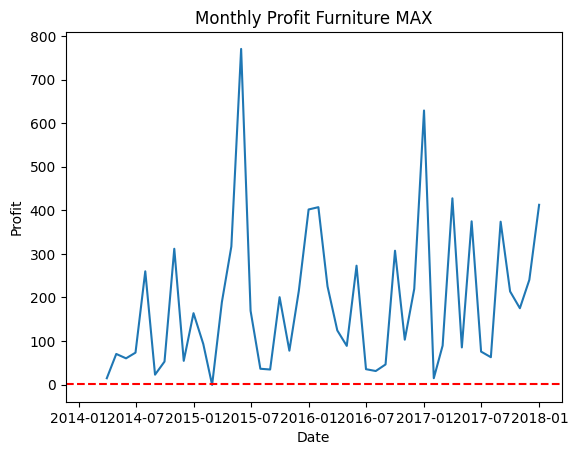

In [46]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').max()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} MAX")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

# Monthly Sales

Technology


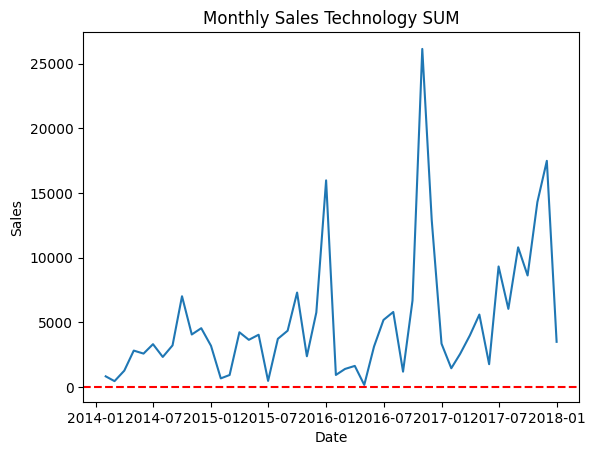

Office Supplies


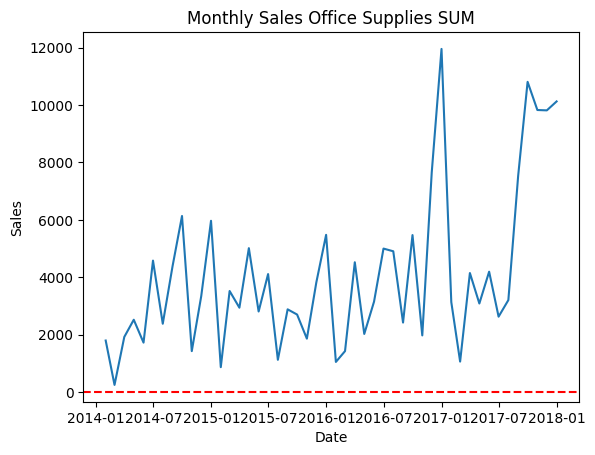

Furniture


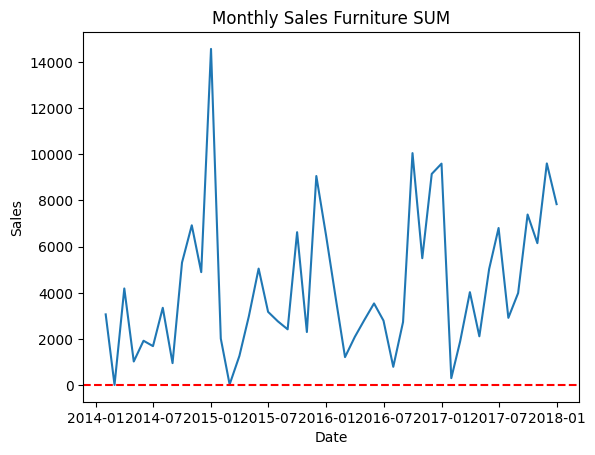

In [47]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').sum()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Sales'])
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Monthly Sales {v} SUM")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


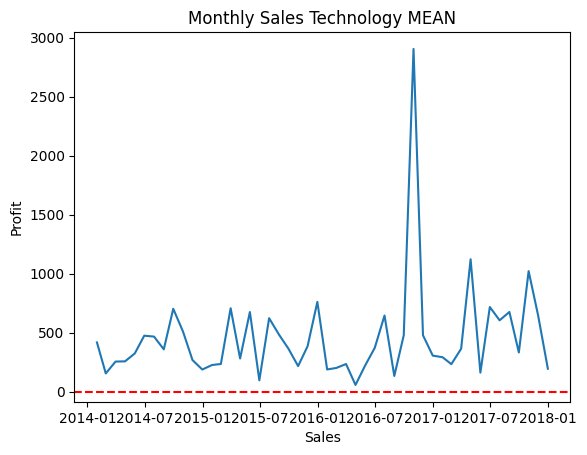

Office Supplies


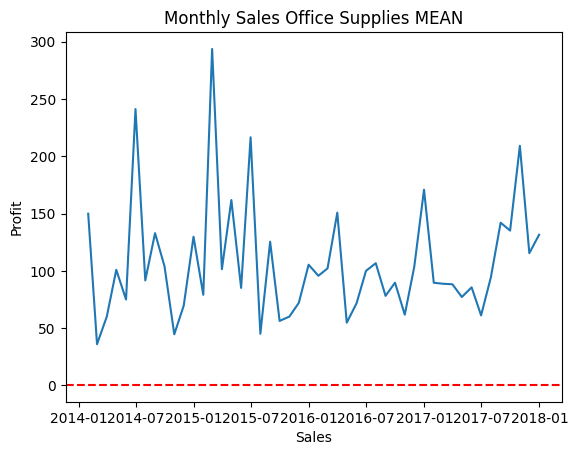

Furniture


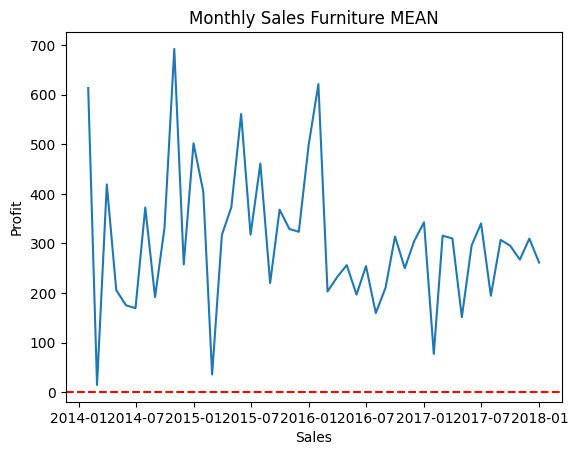

In [48]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').mean()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Sales'])
    plt.xlabel("Sales")
    plt.ylabel("Profit")
    plt.title(f"Monthly Sales {v} MEAN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


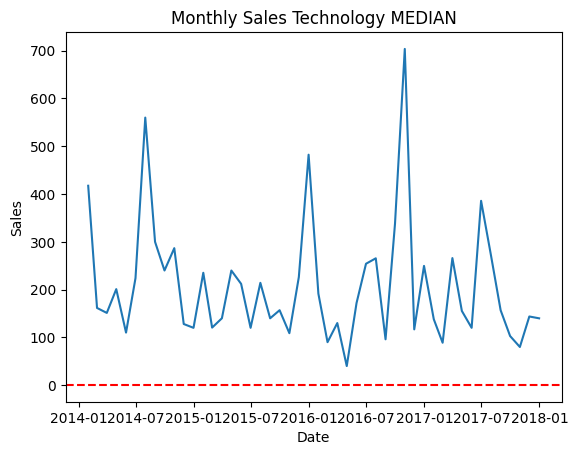

Office Supplies


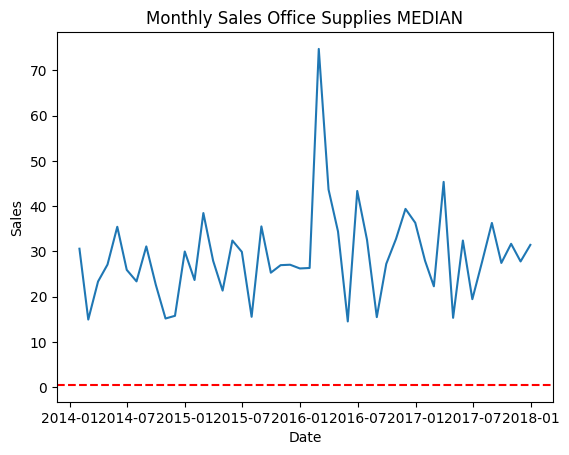

Furniture


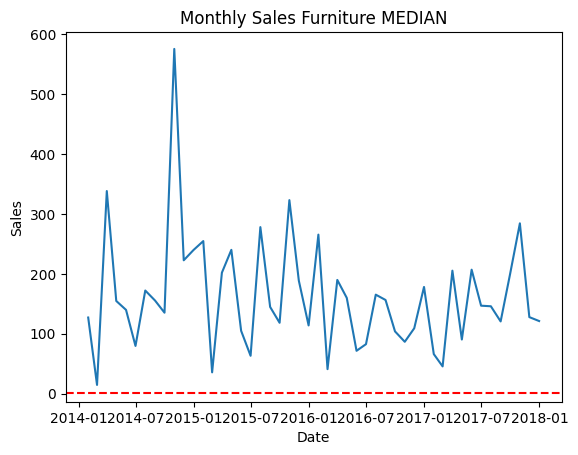

In [49]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').median()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Sales'])
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Monthly Sales {v} MEDIAN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


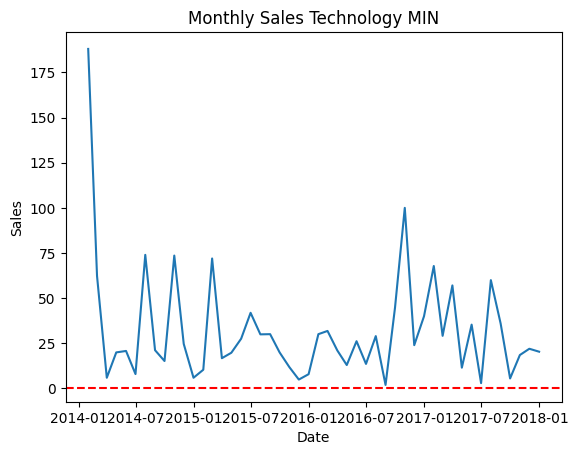

Office Supplies


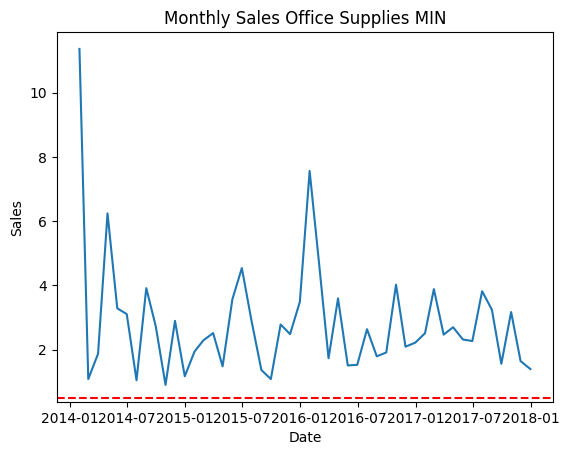

Furniture


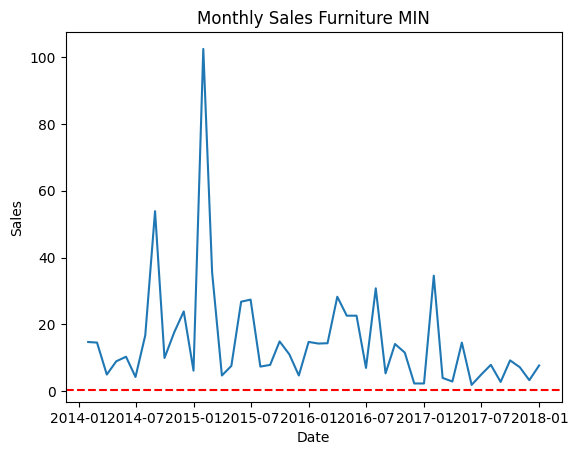

In [50]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').min()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Sales'])
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Monthly Sales {v} MIN")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

Technology


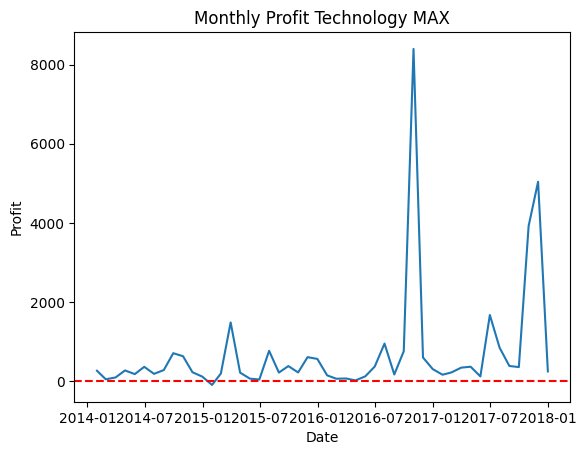

Office Supplies


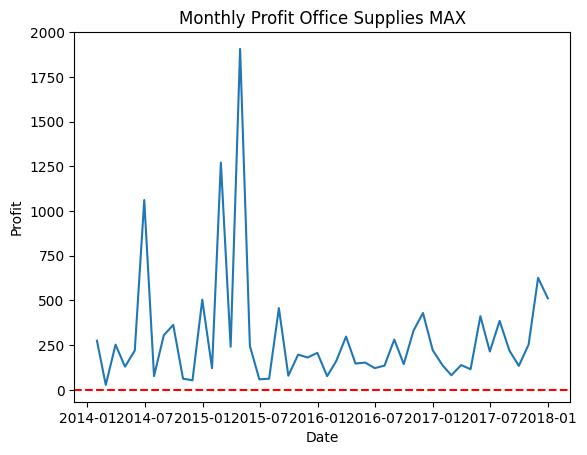

Furniture


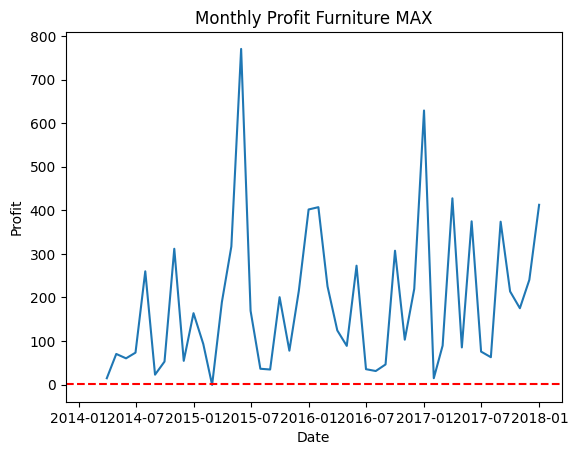

In [51]:
for i, v in enumerate(df["Category"].unique()):
    print(v)
    # Resample the data to monthly intervals and calculate the mean
    monthly_data = df_sample[df_sample["Category"] == v].resample('M').max()

    # Create a line chart of the resampled data
    plt.plot(monthly_data.index, monthly_data['Profit'])
    plt.xlabel("Date")
    plt.ylabel("Profit")
    plt.title(f"Monthly Profit {v} MAX")
    plt.axhline(y=0.5, color='r', linestyle='--')

    # Show the plot
    plt.show()

# SQL

In [52]:
conn = connect(':memory:')
df.to_sql('data', conn)

9993

# Furniture

In [53]:
furniture = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,COUNT("Order ID") AS Count
        ,SUM("Sales") AS Sales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Furniture')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [54]:
# furniture_pivot = pd.pivot_table(furniture, values='Count', index=['Order Year', 'Category'],
#                           columns=['Order Month'], aggfunc=sum, fill_value=0)

In [55]:
# furniture_pivot

In [56]:
# # iterate over the multi-index
# for index, group in furniture_pivot.groupby(level=['Order Year', 'Category']):
# #     print('Order Year:', index[0])
#     print('Category:', index[1])
# #     print(group)

In [57]:
furniture_pivot = pd.pivot_table(furniture, values='Count', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [58]:
furniture_pivot

Order Month  01  02  03  04  05  06  07  08  09  10  11   12
Order Year                                                  
2014         20   7  33  26  24  30  33  24  56  32  62   74
2015         15  11  28  33  30  26  40  32  60  36  77   64
2016         22  19  41  35  43  38  39  29  83  48  81   84
2017         24  26  38  44  53  51  52  39  83  71  99  106

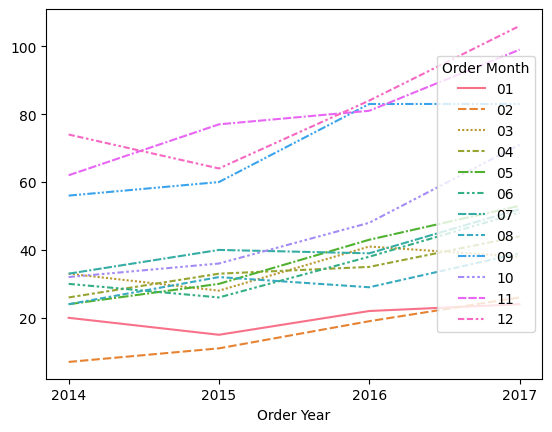

In [59]:
ax = sns.lineplot(data=furniture_pivot)
sns.move_legend(ax, "center right")

In [60]:
furniture_pivot = pd.pivot_table(furniture, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

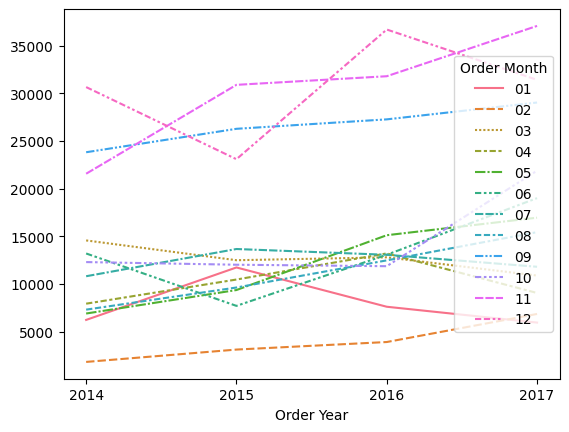

In [61]:
ax = sns.lineplot(data=furniture_pivot)
sns.move_legend(ax, "center right")

In [62]:
furniture_pivot = pd.pivot_table(furniture, values='Profit', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

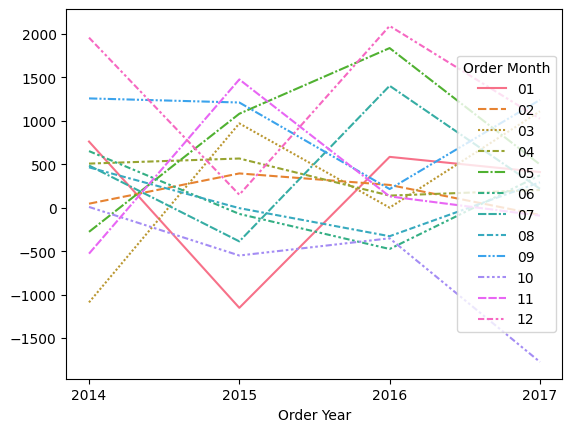

In [63]:
ax = sns.lineplot(data=furniture_pivot)
sns.move_legend(ax, "center right")

# Technology

In [64]:
technology = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,COUNT("Order ID") AS Count
        ,SUM("Sales") AS Sales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Technology')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [65]:
technology_pivot = pd.pivot_table(technology, values='Count', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

In [66]:
technology_pivot

Order Month  01  02  03  04  05  06  07  08  09  10  11  12
Order Year                                                 
2014          9   8  22  26  27  21  28  27  46  30  61  50
2015         11  14  28  37  22  27  22  31  48  41  60  67
2016         22  16  37  22  42  36  34  37  50  29  73  61
2017         31  22  55  26  43  45  49  36  92  57  93  75

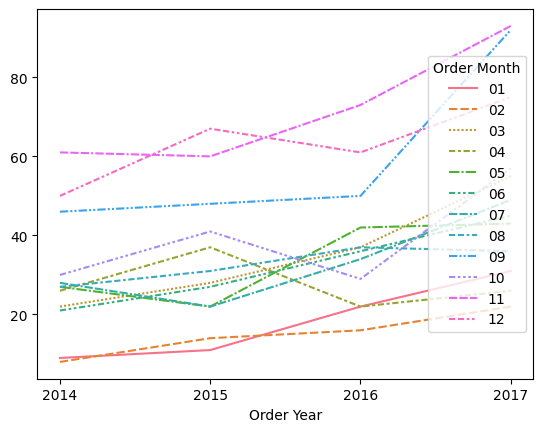

In [67]:
ax = sns.lineplot(data=technology_pivot)
sns.move_legend(ax, "center right")

In [68]:
technology_pivot = pd.pivot_table(technology, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

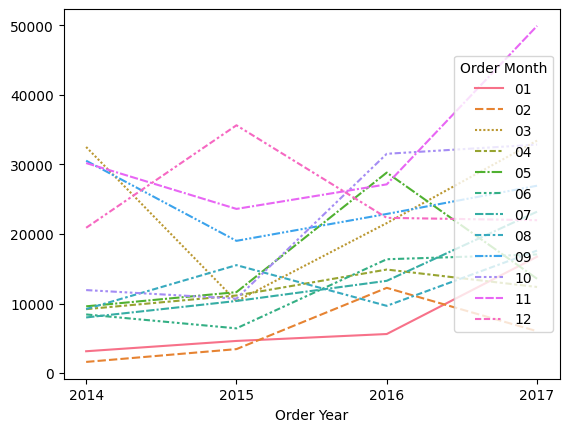

In [69]:
ax = sns.lineplot(data=technology_pivot)
sns.move_legend(ax, "center right")

In [70]:
technology_pivot = pd.pivot_table(technology, values='Profit', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

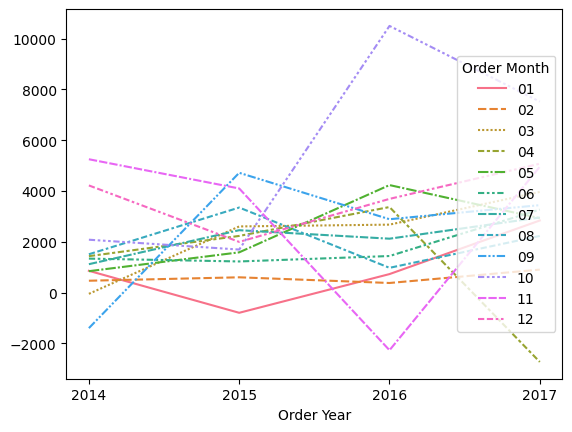

In [71]:
ax = sns.lineplot(data=technology_pivot)
sns.move_legend(ax, "center right")

# Office supplies

In [72]:
office_supplies = pd.read_sql(
"""
    SELECT
        "Order Year"
        ,"Order Month"
        ,Category
        ,COUNT("Order ID") AS Count
        ,SUM("Sales") AS Sales
        ,SUM("Profit") AS Profit
    FROM data
    WHERE
        Category IN ('Office Supplies')
    GROUP BY
        "Order Year"
        ,"Order Month"
        ,Category
    
""",
conn
)

In [73]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Count', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

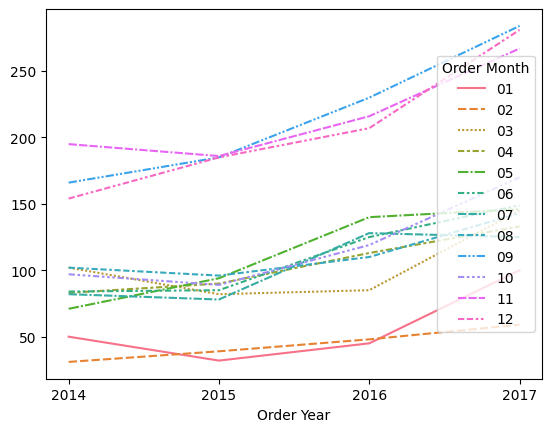

In [74]:
ax = sns.lineplot(data=office_supplies_pivot)
sns.move_legend(ax, "center right")

In [75]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Sales', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

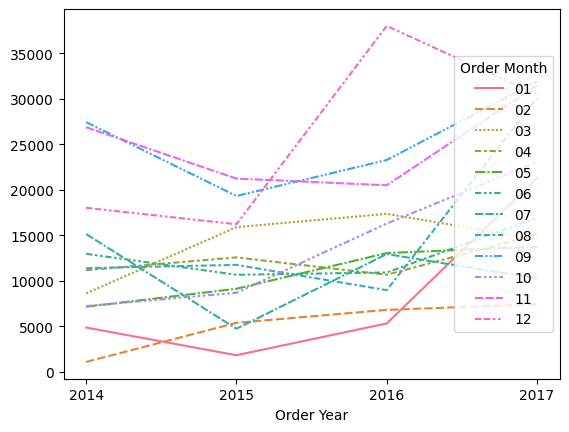

In [76]:
ax = sns.lineplot(data=office_supplies_pivot)
sns.move_legend(ax, "center right")

In [77]:
office_supplies_pivot = pd.pivot_table(office_supplies, values='Profit', index=['Order Year'],
                          columns=['Order Month'], aggfunc=sum, fill_value=0)

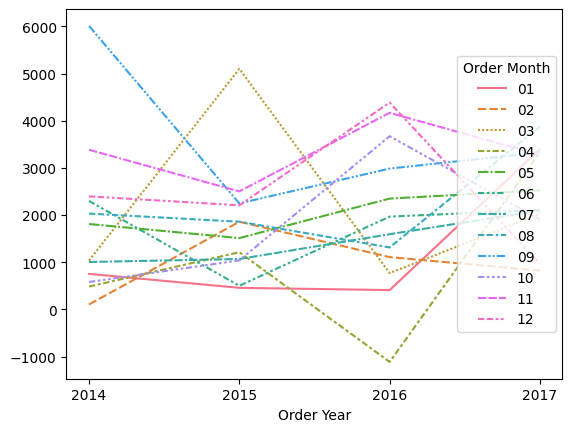

In [78]:
ax = sns.lineplot(data=office_supplies_pivot)
sns.move_legend(ax, "center right")